In [1]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.colors as mcolors
import plotly.express as px

ROOT_DIR /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [2]:

#plt.ion()

In [3]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':['popsize','seed','sigma'],
	'pso':['popsize', 'w','seed', 'c1', 'c2'],
	'bo-ucb':['seed','kappa'],
	'bo-ei': ['seed','xi'],
	'bo-poi': ['seed','xi']
}

#goMethods = list(hypers.keys())
goMethods = ['pso', 'cma', 'bo']
print(goMethods)

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations
['pso', 'cma', 'bo']


In [4]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

globalOptimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()

print(globalOptimals)

numthreads = 56 if MACHINE in 'ruby' else 80
globalBaselines = xtimeDB.loc[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'cores')
										& (xtimeDB['OMP_SCHEDULE'] == 'static'),['progname', 'probsize', 'xtime']]

probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

       progname probsize       xtime
0        bt_nas  lrgprob  745.260000
1        bt_nas  medprob   31.943333
2        bt_nas  smlprob    7.383333
3   cfd_rodinia  lrgprob    9.222637
4   cfd_rodinia  medprob    4.186460
5   cfd_rodinia  smlprob    1.578907
6        cg_nas  lrgprob  176.373333
7        cg_nas  medprob    4.796667
8        cg_nas  smlprob    1.143333
9        ft_nas  lrgprob  138.460000
10       ft_nas  medprob    3.903333
11       ft_nas  smlprob    0.940000
12         hpcg  lrgprob   65.220033
13         hpcg  medprob   17.178033
14         hpcg  smlprob    1.949250
15       lulesh  lrgprob   18.396099
16       lulesh  medprob    9.995197
17       lulesh  smlprob    4.854440


In [5]:
overallDF = pd.DataFrame()
tojoin = []
for progname in prognames:
	if progname == 'cg_nas' or progname == 'cfd_rodinia':
		continue
	for method in goMethods:
		# read the pre-processed dataframes
		filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-rawXtimes.csv'
		fullDF = pd.read_csv(filename)
		tojoin += [fullDF]

overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)

print(overallDF.columns)
overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
overallDF = overallDF.drop(['utilFnct'], axis=1)

for col in overallDF:
	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
		continue
	print(col, overallDF[col].unique())

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize',
       'progname', 'seed', 'sigma', 'utilFnct', 'w', 'xi', 'xtime'],
      dtype='object')
c1 [0.1  0.45 0.8  1.15 1.5   nan]
c2 [0.1  0.45 0.8  1.15 1.5   nan]
kappa [ nan   2.   8.  15.  22.  29.  36.  42.  49.  56.  63.  70.  77.  83.
  90.  97. 104. 111. 118. 124. 131. 138. 145. 152. 159. 165. 172. 179.
 186. 193. 200.]
method ['pso' 'cma' 'bo-ei' 'bo-ucb' 'bo-poi']
popsize [18.  3. 21.  6. 24.  9. 27. 12. 30. 15. nan]
probsize ['smlprob' 'medprob' 'lrgprob']
progname ['bt_nas' 'ft_nas' 'hpcg' 'lulesh']
seed [1337 3827 9999 4873]
sigma [   nan  1.     4.222  7.444 10.667 13.889 17.111 20.333 23.556 26.778
 30.   ]
w [0.1   0.325 0.55  0.775 1.      nan]
xi [  nan 0.    0.357 0.714 1.071 1.429 1.786 2.143 2.5   2.857 3.214 3.571
 3.929 4.286 4.643 5.   ]


In [6]:
def drawParetoPlot(*args, **kwargs):
	df = kwargs.pop('data').copy(deep=True)

	method = df['method'].iat[0]
	progname = df['progname'].iat[0]
	probsize = df['probsize'].iat[0]

	cols = hypers[method]
	#print('cols', cols)

	colsToKeep = cols+['globalSample', 'xtime']
	df = df[colsToKeep]

	df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

	#print('dropped cols')
	#print(df.head())

	# need to make one column with the cummax and grab the 300th step
	df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')

	#print('pre new index')
	#print(df.head())

	# rescale the xtime to be baseline-normalized
	df = df.set_index(cols)

	# do the baseline normalization here
	baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = baselineXtime/optimalXtime

	df['baselineXtime'] = baselineXtime/df['cummin']

	#print(f'{method} {progname} {probsize}')
	#print(df.head())

	# now make a new df with just the unique values of the hyperparam columns
	# the 'baselineXtime' column will be the max speedup we get after 300 steps
	#toplot = df[df['globalSample'] == 299.0]

	earliestSamples = pd.DataFrame(index=df.index.copy())
	earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
	earliestSamples['firstSample'] = 301
	earliestSamples['maxSpeedup'] = 0

	# now for each index, find the earliest globalSample that is greater than 1.0
	#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
	firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
	maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

	earliestSamples['firstSample'].update(firstSamp)
	earliestSamples['maxSpeedup'].update(maxSpeed)
	#earliestSamples = earliestSamples.reset_index()

	# drop the configurations that never reach the baseline
	#earliestSamples = earliestSamples.dropna(how='any')

	#print('earliestSamples')
	#print(earliestSamples.head())
	#print(earliestSamples.tail())


	#ax = plt.gca()
	
	ax = sns.scatterplot(earliestSamples, x='maxSpeedup', y='firstSample')

	ax.set_xlabel('Max Speedup after 300 steps')
	ax.set_ylabel('Earliest Timestep Surpassing Baseline Execution Time')
	ax.axvline(1.0, label='Baseline Speedup', zorder=0, c='red')
	ax.axvline(optimalXtime, label='Optimal Speedup', zorder=0, c='blue')
	#ax.legend()
	#ax.set_ylim(0, 302)
	#ax.set_xlim(0, optimalXtime+(0.02*optimalXtime))

	return

def makeParetoPlots(df, progname):
	#print(df.shape)
	#print(df.columns)

	df = df[df['progname'] == progname].reset_index(drop=True)

	#print(df.shape)
	#print(df.columns)

	g = sns.FacetGrid(df, row='method', col='probsize', col_order=probsizes, height=10, aspect=1.5, sharex=False, sharey=False)
	g.map_dataframe(drawParetoPlot, annot=True, xticklabels=True, yticklabels=True)
	
	for ax in g.axes.flatten():
		#ax.tick_params(axis='x', labelbottom=True, labelrotation=90)
		ax.legend(loc='best')
	
	#plt.tight_layout()
	g.set_titles(col_template="Problem Size: {col_name}", row_template="GO Method: {row_name}")
	
	g.fig.subplots_adjust(top=0.96)
	g.fig.suptitle(f'GO Hyperparam Comparison ({progname.upper()})')
	
	plt.show()
	

	return

In [7]:
#makeParetoPlots(overallDF, 'bt_nas')
#makeParetoPlots(overallDF, 'ft_nas')
#makeParetoPlots(overallDF, 'hpcg')
#makeParetoPlots(overallDF, 'lulesh')

In [8]:
# now let's make the same plots in plotly


In [9]:
print(overallDF.columns)
print(overallDF.shape)

gomethods = list(hypers.keys())
print(gomethods)

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize',
       'progname', 'seed', 'sigma', 'w', 'xi', 'xtime'],
      dtype='object')
(20304000, 13)
['cma', 'pso', 'bo-ucb', 'bo-ei', 'bo-poi']


In [10]:
def tupleizeCols(df, cols):
	newColName = f'({",".join([str(col) for col in cols])})'
	df[newColName] = pd.Categorical(list(zip(*[df[col] for col in cols])))
	#df['code'] = df[newColName].cat.codes
	df = df.drop(cols, axis=1)
	return df, newColName

def fix_fig(fig, labels):
	fig.for_each_xaxis(lambda x: x.update(title = ''))
	fig.add_annotation(x=0.5,y=-0.2,
              text=labels['maxSpeedup'],
               xref="paper", yref="paper")
	fig.for_each_yaxis(lambda y: y.update(title = ''))
	fig.add_annotation(x=-0.05,y=0.5, 
              text=labels['firstSample'], textangle=-90,
               xref="paper", yref="paper")
	fig.show()
	return

In [11]:
def doPlotlyPlots(overallDF, progname):
	# for each progname, probsize, method combo
	# let's make the plots
	for method in gomethods:
		for probsize in probsizes:
			df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
			#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
			cols = hypers[method]
			colsToKeep = cols+['globalSample', 'xtime']
			df = df[colsToKeep]
			df = df.sort_values(by=cols+['globalSample'], ignore_index=True)


			df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
			df = df.set_index(cols)
			baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = baselineXtime/optimalXtime
			df['baselineXtime'] = baselineXtime/df['cummin']

			earliestSamples = pd.DataFrame(index=df.index.copy())
			earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
			earliestSamples['firstSample'] = 300
			earliestSamples['maxSpeedup'] = 0

			# now for each index, find the earliest globalSample that is greater than 1.0
			#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
			firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
			maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

			earliestSamples['firstSample'].update(firstSamp)
			earliestSamples['maxSpeedup'].update(maxSpeed)

			earliestSamples = earliestSamples.reset_index()

			labels = {
				'firstSample': 'Earliest Timestep Surpassing Baseline Execution Time',
				'maxSpeedup': 'Max Speedup after 300 steps'
			}
			width = 900
			height = 400
			palette = 'BlueRed'
			#if method == 'pso':
			#	earliestSamples, newColName = tupleizeCols(earliestSamples, ['w', 'c1', 'c2'])
			#	newColName = 'code'
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='popsize', color=newColName, color_continuous_scale='Reds', #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'cma':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
			#									 z='popsize', color='sigma', color_continuous_scale='Reds', #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-ei':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='xi', title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-poi':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='xi', title=f'{progname}-{probsize}-{method}', 
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-ucb':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='kappa', title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)

			if method == 'pso':
				#earliestSamples, newXCol = tupleizeCols(earliestSamples, ['popsize', 'w'])
				#earliestSamples, newYCol = tupleizeCols(earliestSamples, ['c1', 'c2'])

				#fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
				#								 facet_col=newXCol, facet_row=newYCol, #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
				#								 title=f'{progname}-{probsize}-{method}',
				#								 hover_data=list(earliestSamples.columns), width=1000, height=1000)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='popsize', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='w', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='c1', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='c2', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'cma':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
												 facet_col='popsize', color='sigma', color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=500)
			elif method == 'bo-ei':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='xi', title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'bo-poi':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='xi', title=f'{progname}-{probsize}-{method}', 
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'bo-ucb':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='kappa', title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)

			fix_fig(fig, labels)

In [12]:
#doPlotlyPlots(overallDF, 'bt_nas')
#doPlotlyPlots(overallDF, 'hpcg')
#doPlotlyPlots(overallDF, 'ft_nas')
#doPlotlyPlots(overallDF, 'lulesh')

In [13]:
# now let's take the top 10% of configurations 
# the criteria for selecting the top 10% is their euclidean distance
# of: (((300stepMaxSpeedup - optimalSpeedup)/optimalSpeedup)^2 + ((earliestTimestep-0)/299)^2)^(1/2)
# 

def plotTopPoints(overallDF, progname):
	# for each progname, probsize, method combo
	# let's make the plots
	for method in gomethods:
		for probsize in probsizes:
			df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
			#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
			cols = hypers[method]
			colsToKeep = cols+['globalSample', 'xtime']
			df = df[colsToKeep]
			df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

			# drop all the first samples, as they're random
			df = df[df['globalSample'] != 0.0 ]

			df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
			df = df.set_index(cols)
			baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = baselineXtime/optimalXtime
			df['baselineXtime'] = baselineXtime/df['cummin']


			earliestSamples = pd.DataFrame(index=df.index.copy())
			earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
			earliestSamples['firstSample'] = 300
			earliestSamples['maxSpeedup'] = 0

			# now for each index, find the earliest globalSample that is greater than 1.0
			#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
			firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
			maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

			earliestSamples['firstSample'].update(firstSamp)
			earliestSamples['maxSpeedup'].update(maxSpeed)

			earliestSamples = earliestSamples.reset_index()
			# now let's make the distance metric column
			#earliestSamples['score'] = (((earliestSamples['maxSpeedup'] - optimalXtime)/optimalXtime)**2 + (earliestSamples['firstSample']/299)**2)**(1/2)
			earliestSamples['score'] = earliestSamples['maxSpeedup']*0.5  + 0.5*(1/earliestSamples['firstSample'])

			# drop any samples with a score of exactly 0 -- meaning they found the
			# optimal on the first sample (i.e: a lucky sampling...)
			# earliestSamples = earliestSamples[earliestSamples.score != 0.0]

			# create a cutoff score, we keep scores smaller than this
			#cutoff_score = (((1-optimalXtime)/optimalXtime)**2 + (49/300)**2)**(1/2)

			#earliestSamples = earliestSamples[earliestSamples.score < cutoff_score]

			# now cut down on the samples and only show the top 10 configurations 
			earliestSamples = earliestSamples.sort_values(by=['score'], ascending=False)
			earliestSamples = earliestSamples.head(10)
			#top10perc = earliestSamples.shape[0]//10
			#earliestSamples = earliestSamples.head(top10perc)


			labels = {
				'firstSample': 'Earliest Timestep Surpassing Baseline Execution Time',
				'maxSpeedup': 'Max Speedup after 300 steps'
			}
			width = 900
			height = 400
			palette = 'BlueRed'

			#earliestSamples = earliestSamples.drop(['firstSample', 'maxSpeedup'], axis=1)
			
			for col in cols: #list(earliestSamples.columns) #cols:
				earliestSamples[col] = earliestSamples[col].astype('category')
				#ax = earliestSamples[col].value_counts().plot.bar(rot=0)
				#ax.set_title(f'{progname} {probsize} {method} {col}')
				#fig.axes.append(ax)

			melted = earliestSamples.melt(var_name='column')

			#print(melted.head())
			if melted.shape[0] == 0:
				print(f'skipping {progname} {probsize} {method}')
				continue

			g = sns.FacetGrid(melted, col='column', sharex=False, sharey=False)
			g.map(plt.hist, 'value', align='mid', bins=10)
			g.fig.subplots_adjust(top=0.8)
			g.fig.suptitle(f'{progname} {probsize} {method}')

			#def makeBarplot(*args, **kwargs):
			#	print(args[0].shape)
			#	print(kwargs.keys())
			#	df = args[0]#kwargs.pop('data')


			#g = sns.FacetGrid(melted, col='column', sharex=False, sharey=False)
			#g.map(makeBarplot, 'value')
			

			plt.show()
			
			#if method == 'pso':
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 facet_col='popsize', color='score', color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=height)
			#	fix_fig(fig, labels)
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 facet_col='w', color='score', color_continuous_scale=palette, #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=height)
			#	fix_fig(fig, labels)
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 facet_col='c1', color='score', color_continuous_scale=palette, #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=height)
			#	fix_fig(fig, labels)
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 facet_col='c2', color='score', color_continuous_scale=palette, #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=height)
			#elif method == 'cma':
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
			#									 facet_col='popsize', color='score', color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=500)
			#	fix_fig(fig, labels)
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
			#									 facet_col='sigma', color='score', color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=500)
			#elif method == 'bo-ei':
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 facet_col='xi', color='score', color_continuous_scale=palette, title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=height)
			#elif method == 'bo-poi':
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 facet_col='xi', color='score', color_continuous_scale=palette, title=f'{progname}-{probsize}-{method}', 
			#									 hover_data=list(earliestSamples.columns), width=width, height=height)
			#elif method == 'bo-ucb':
			#	fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 facet_col='kappa', color='score', color_continuous_scale=palette, title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=width, height=height)

			#fix_fig(fig, labels)


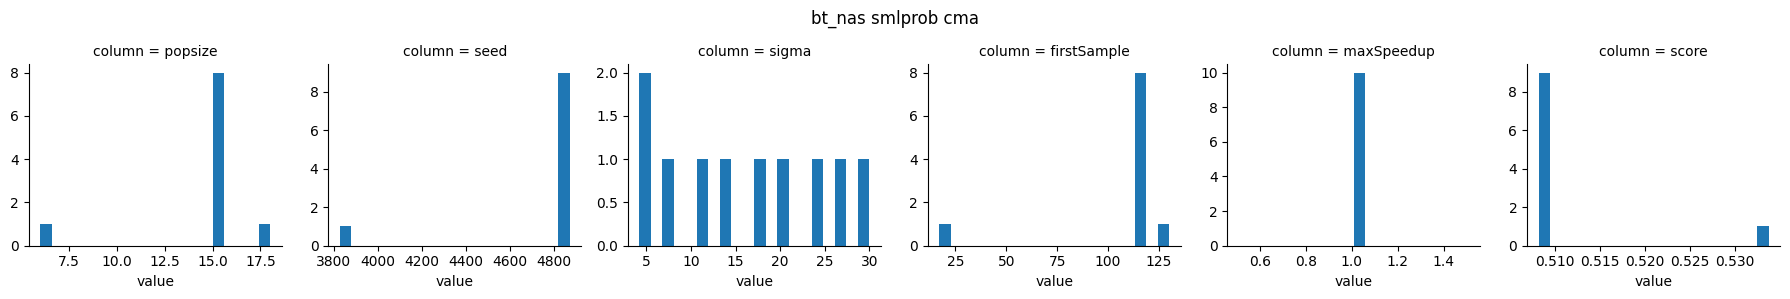

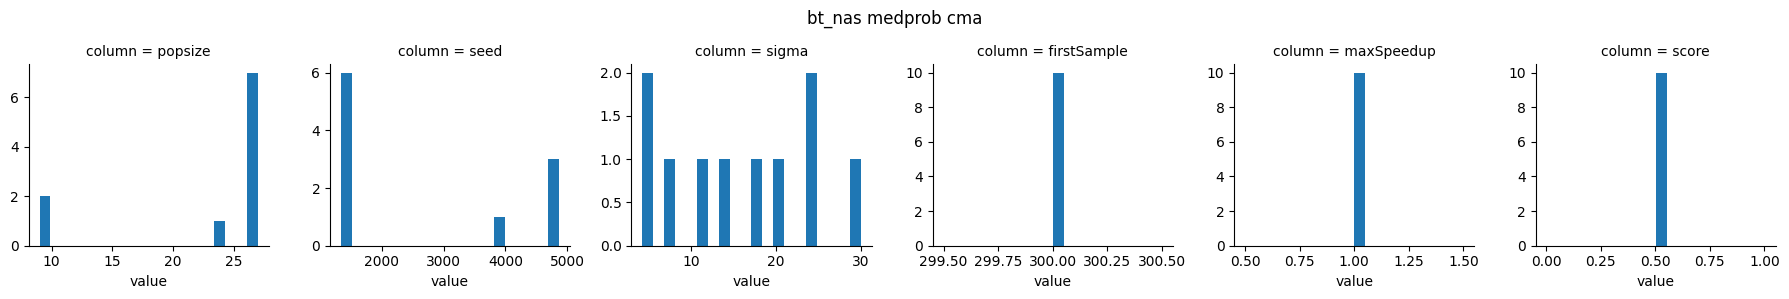

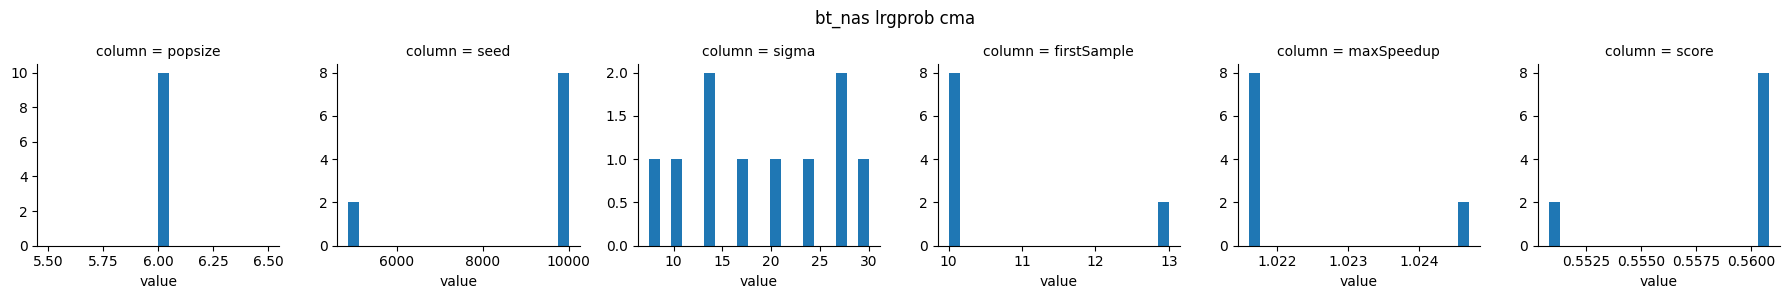

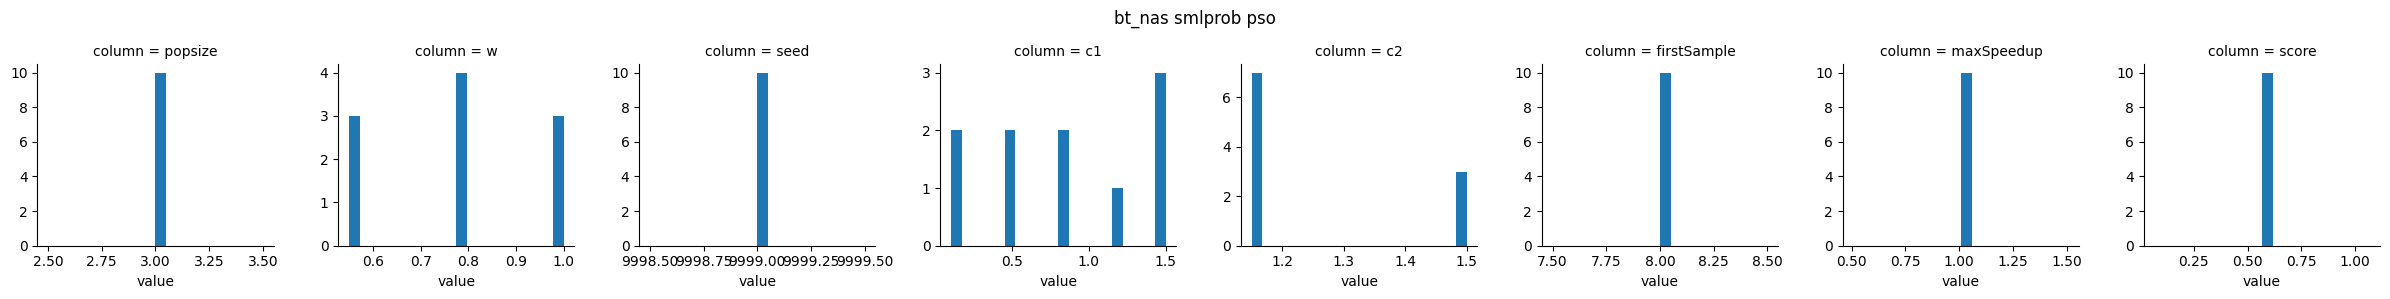

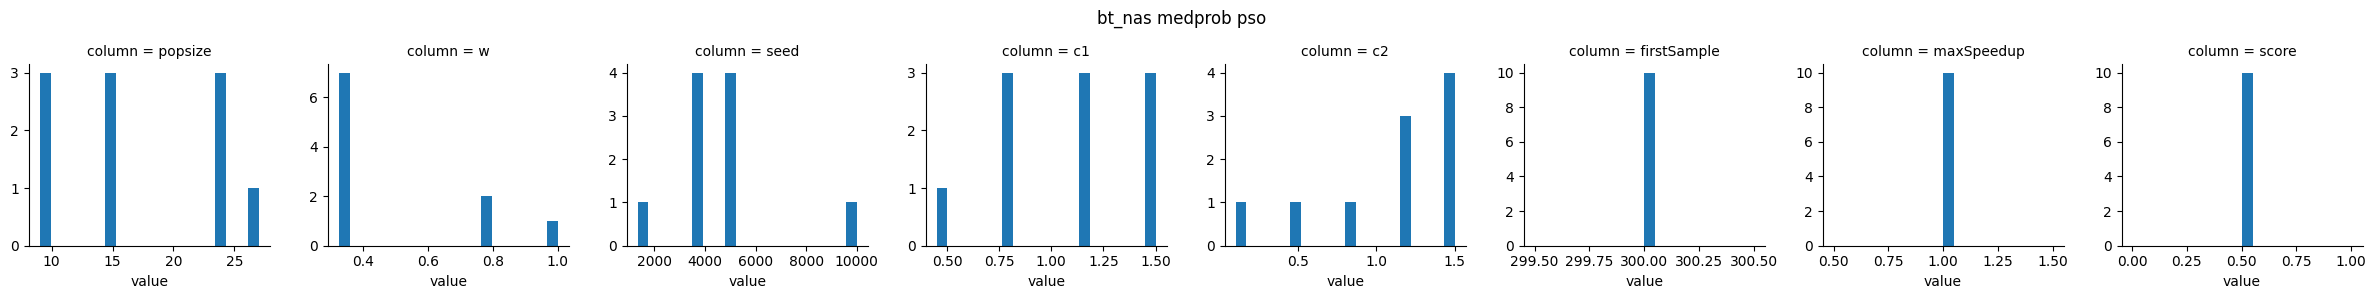

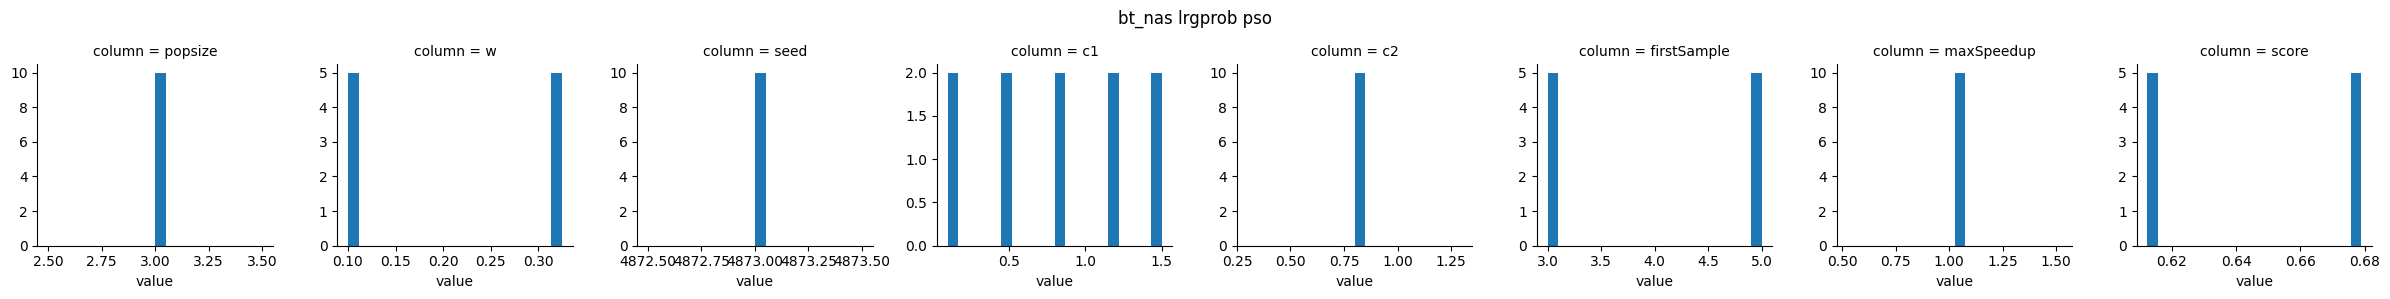

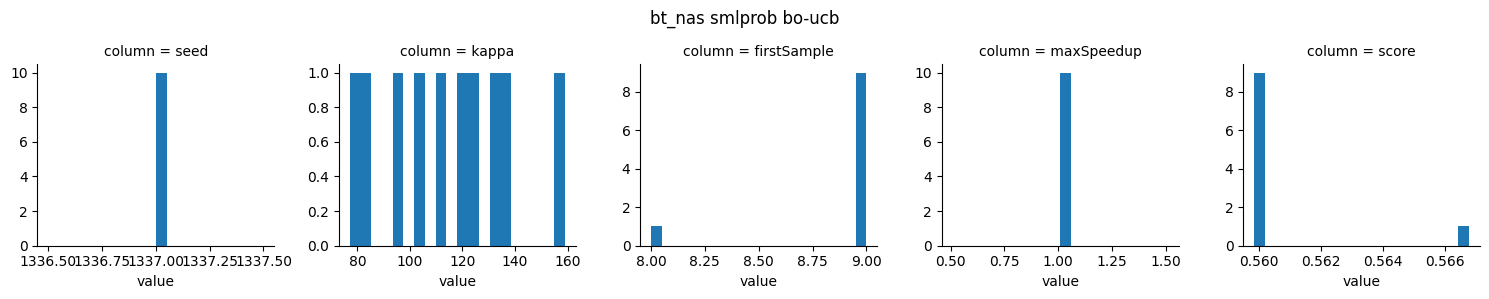

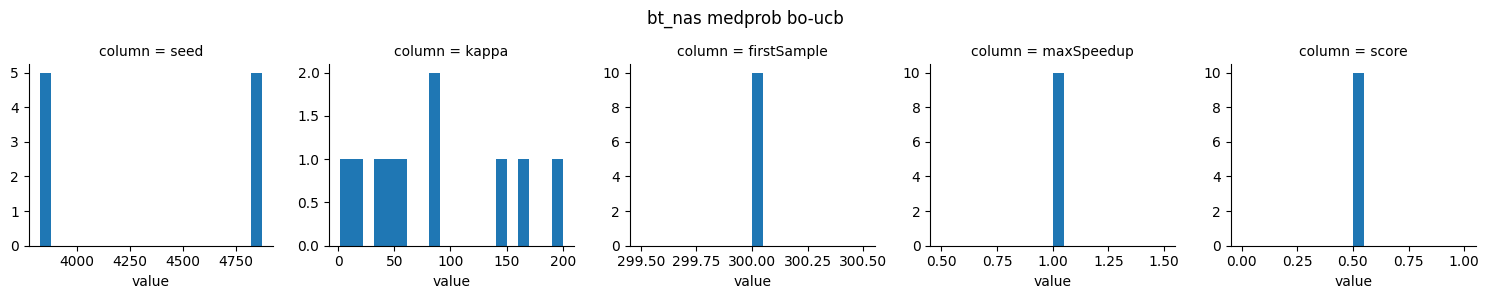

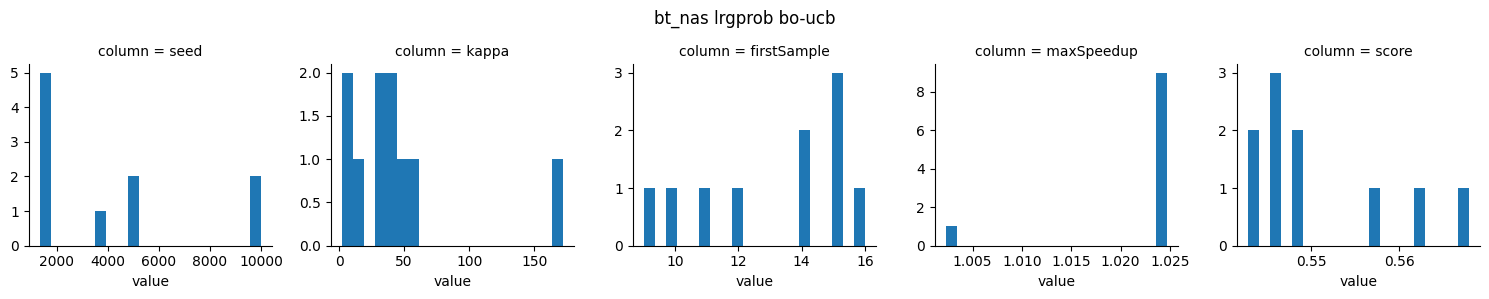

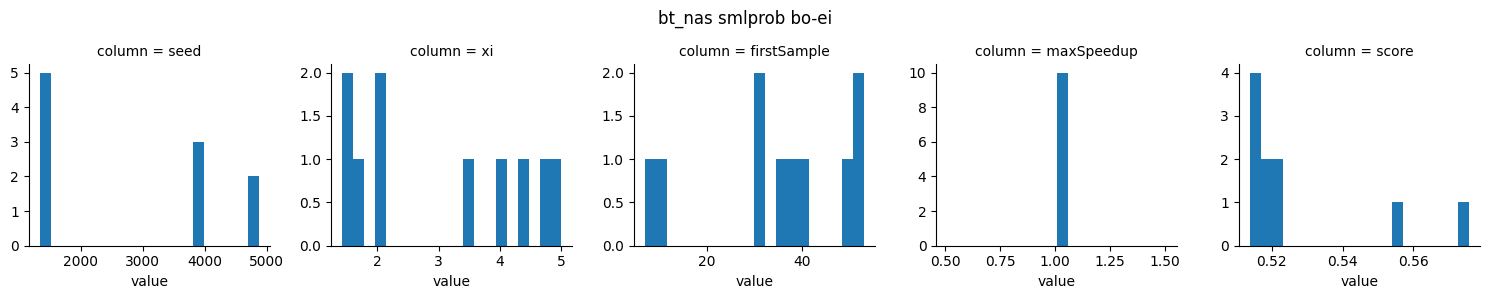

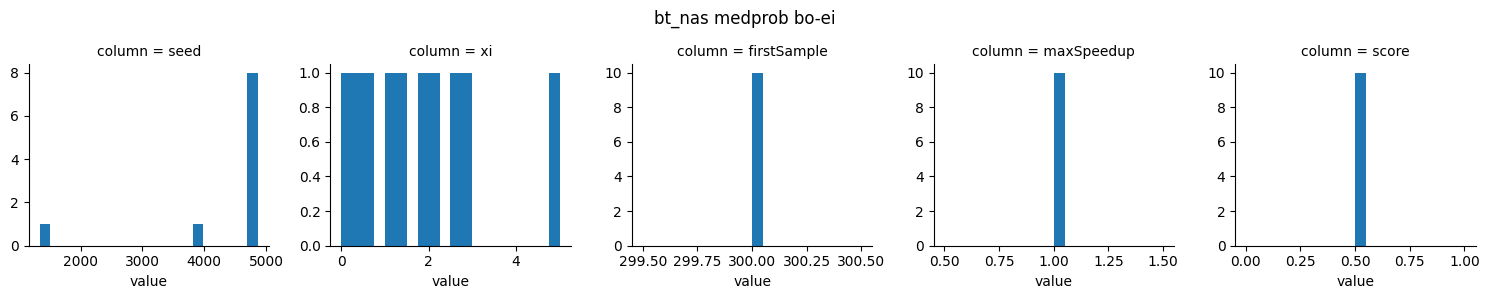

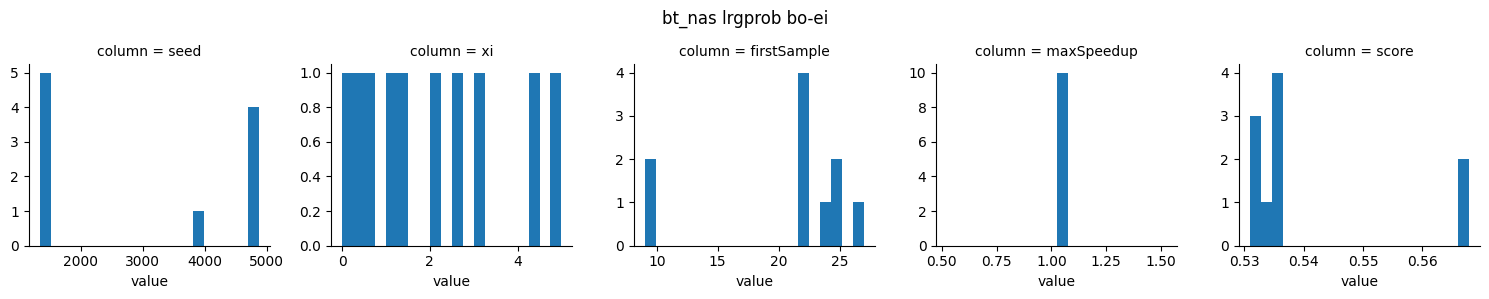

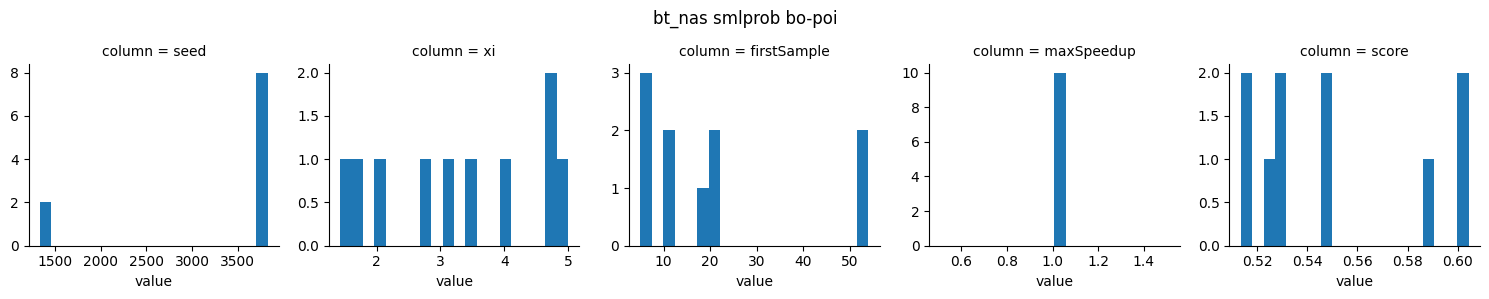

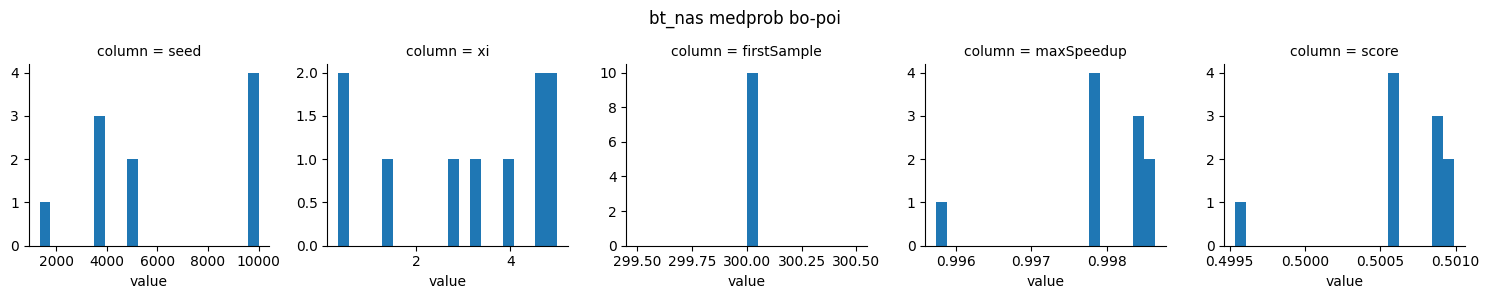

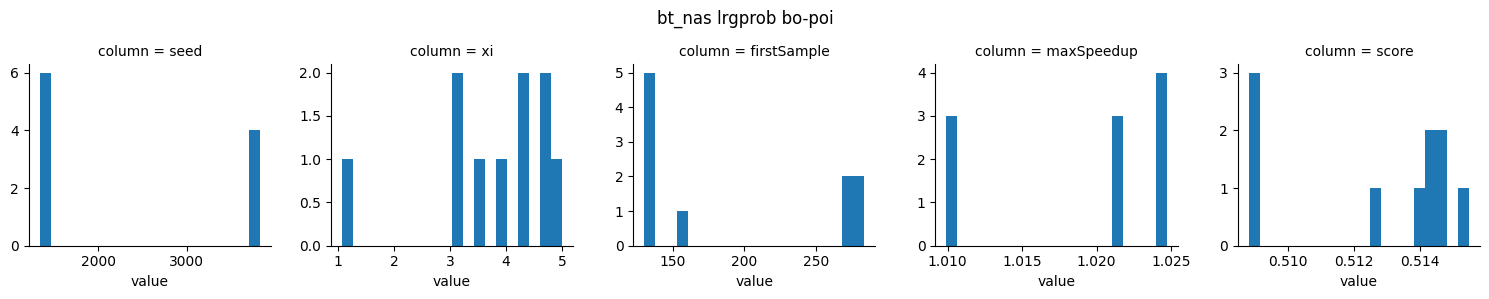

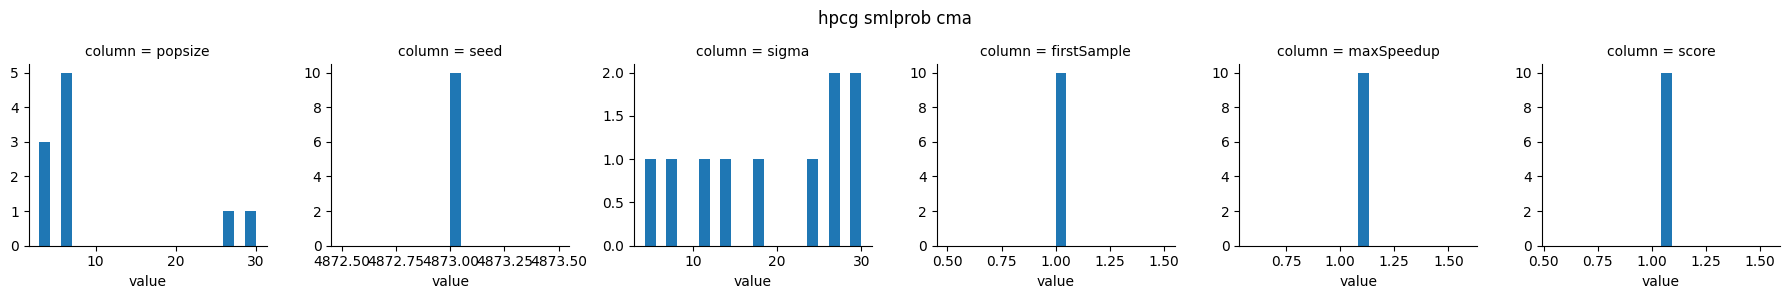

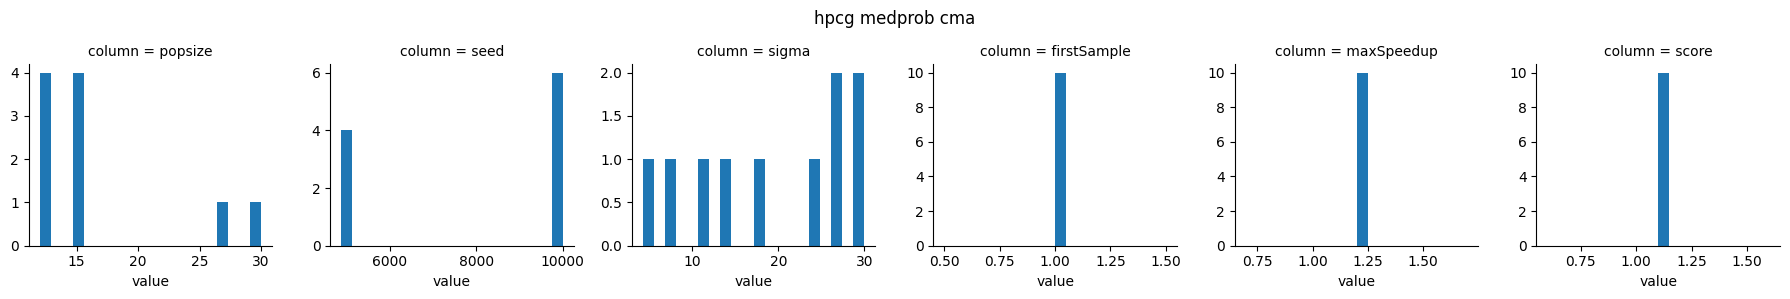

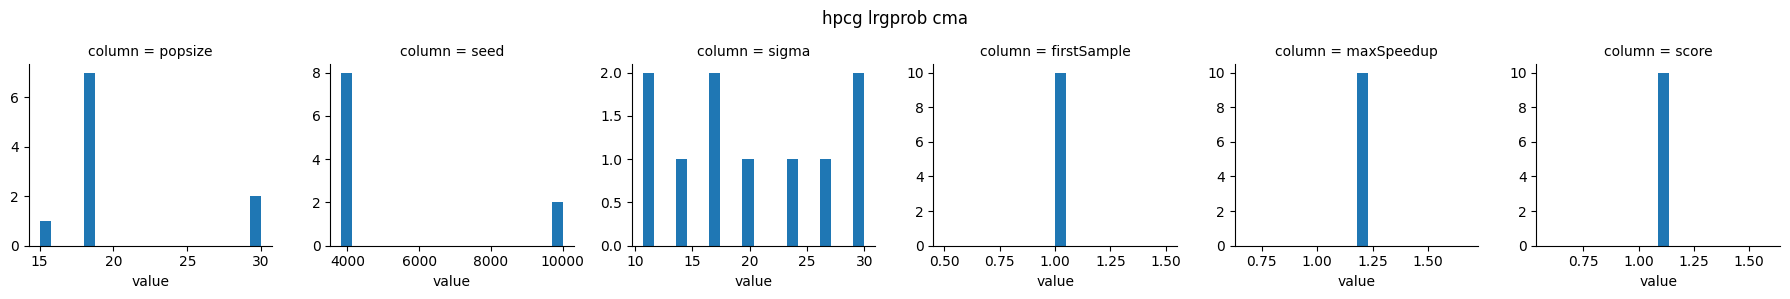

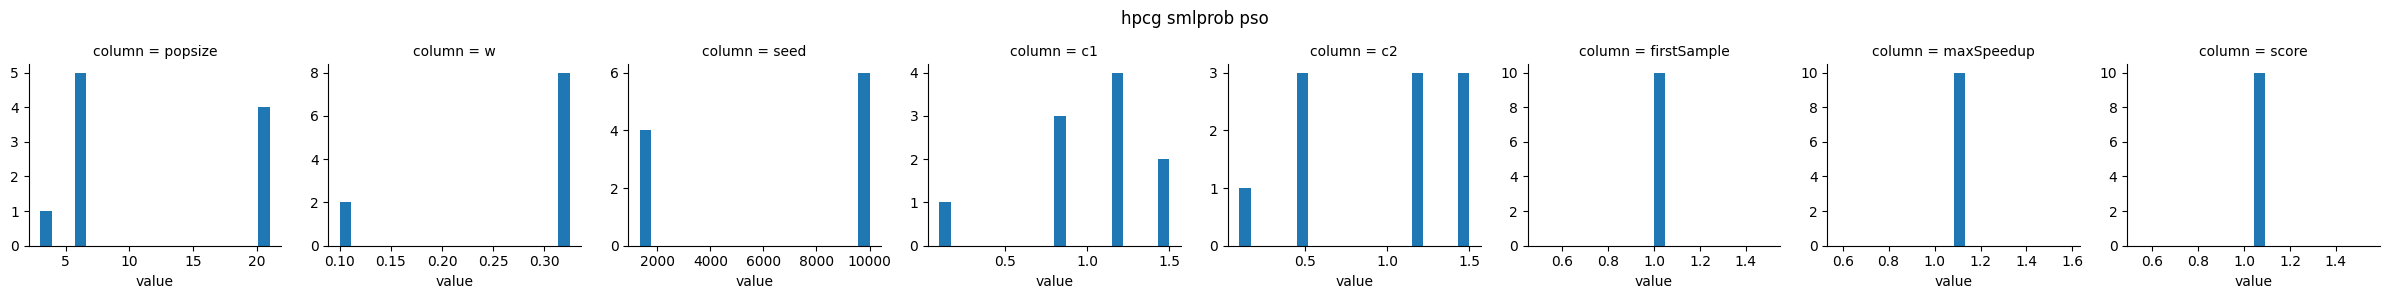

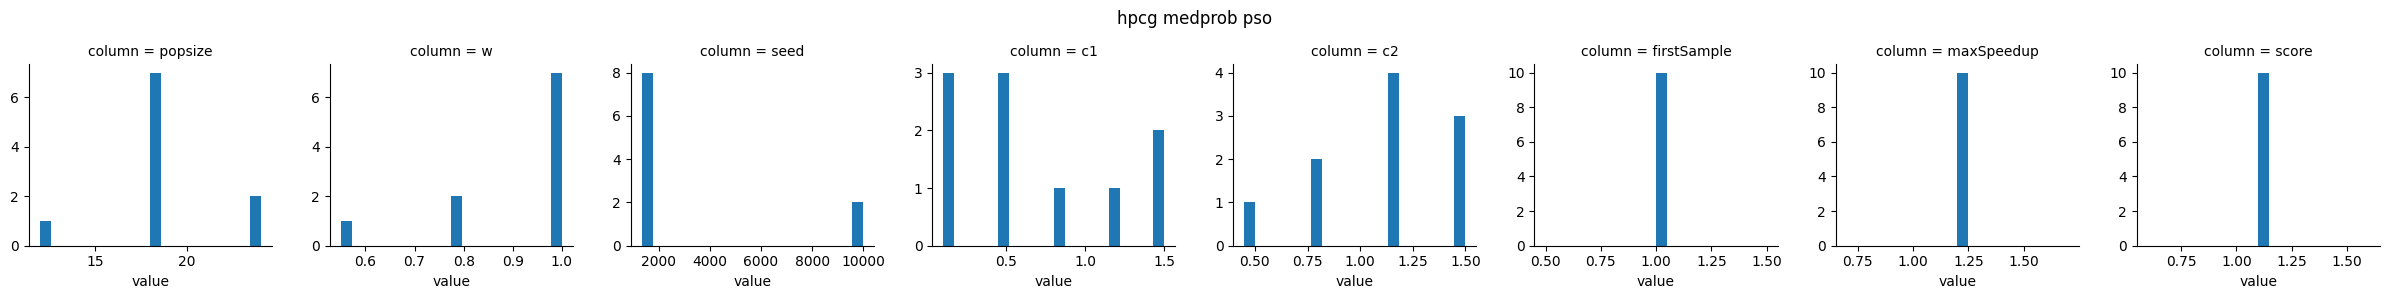

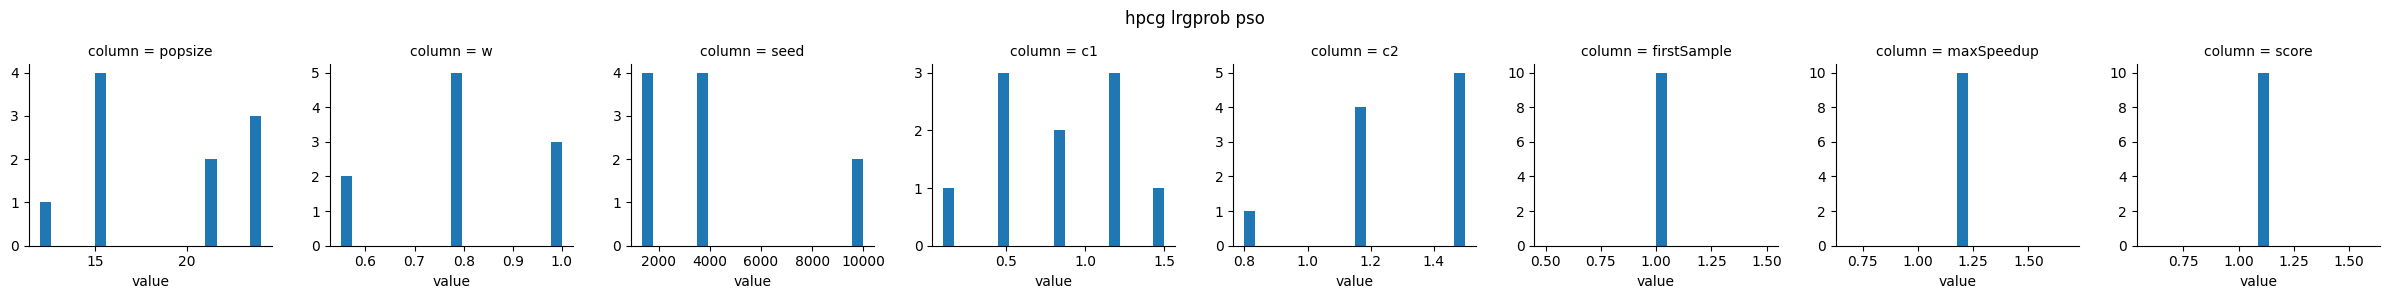

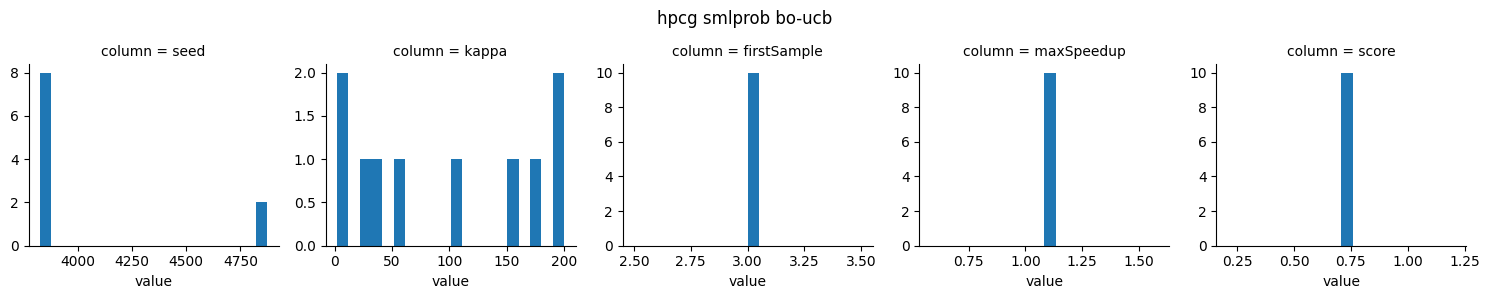

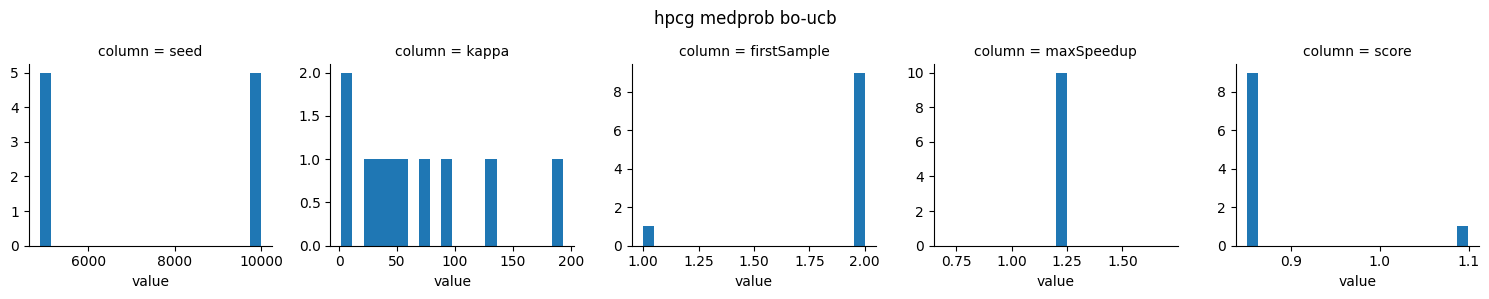

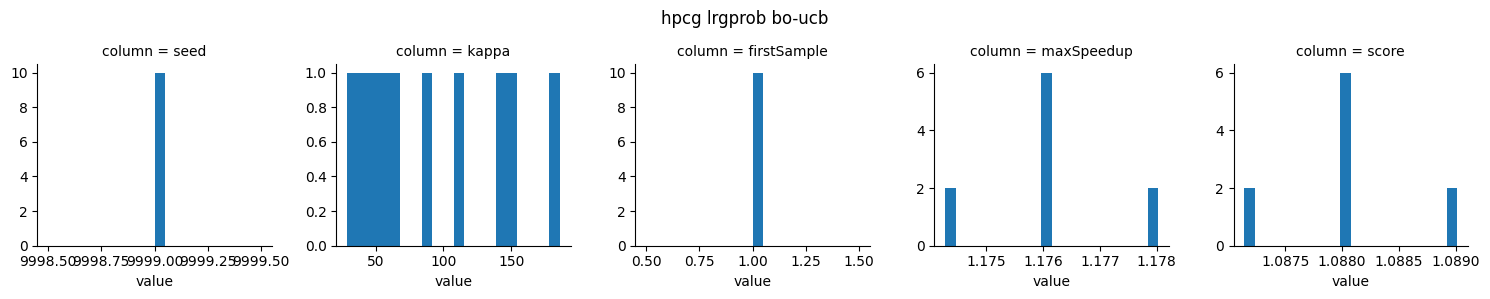

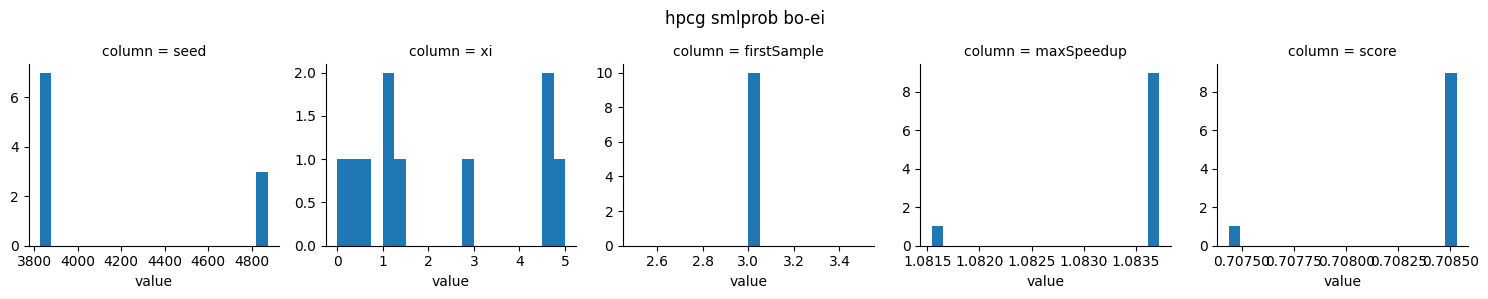

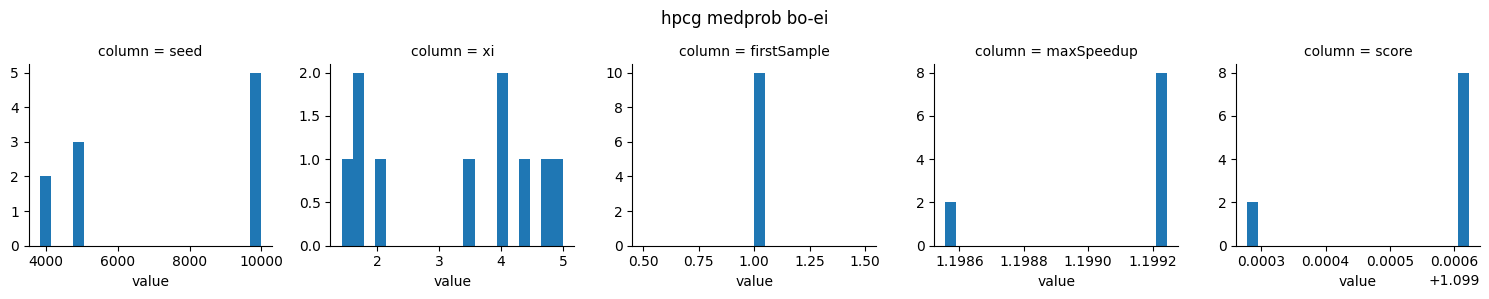

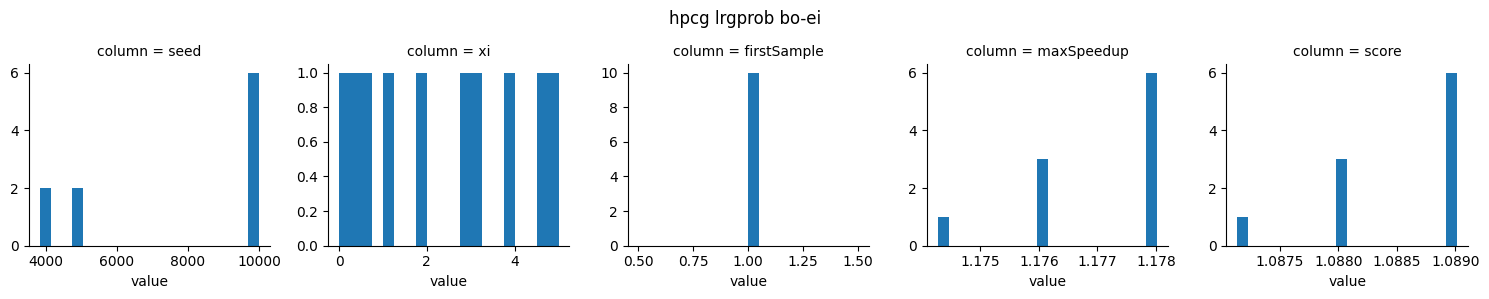

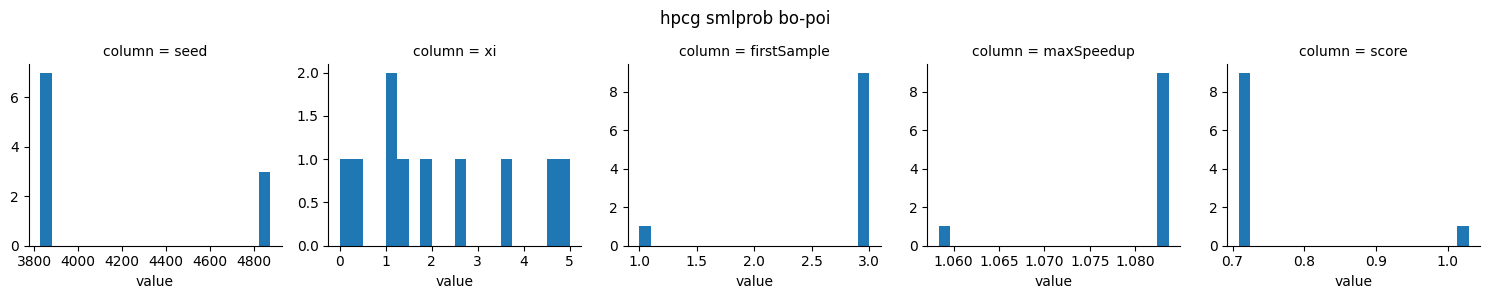

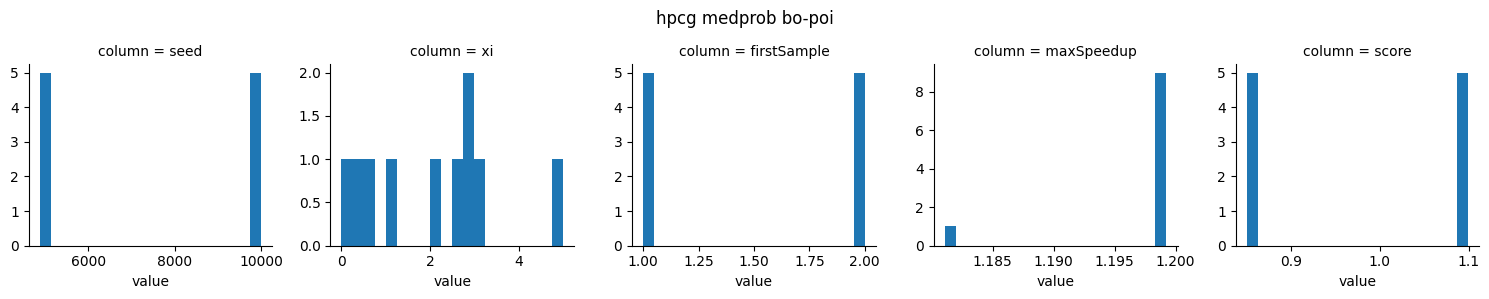

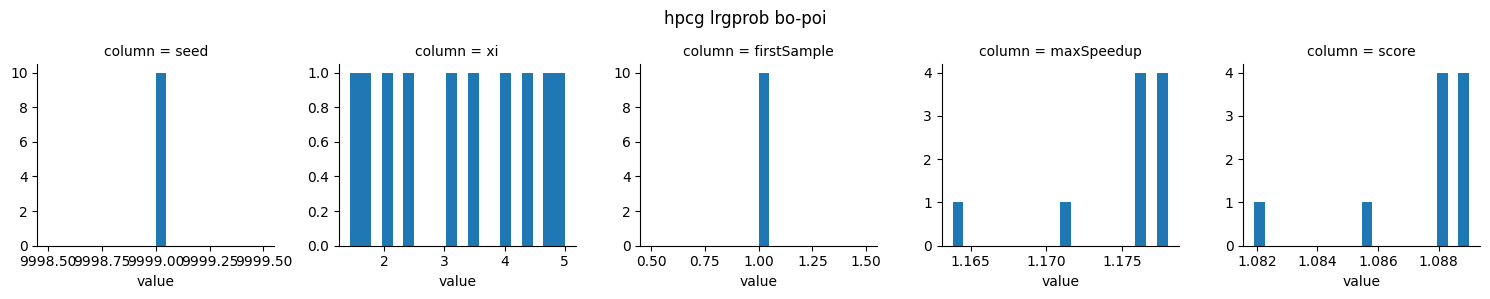

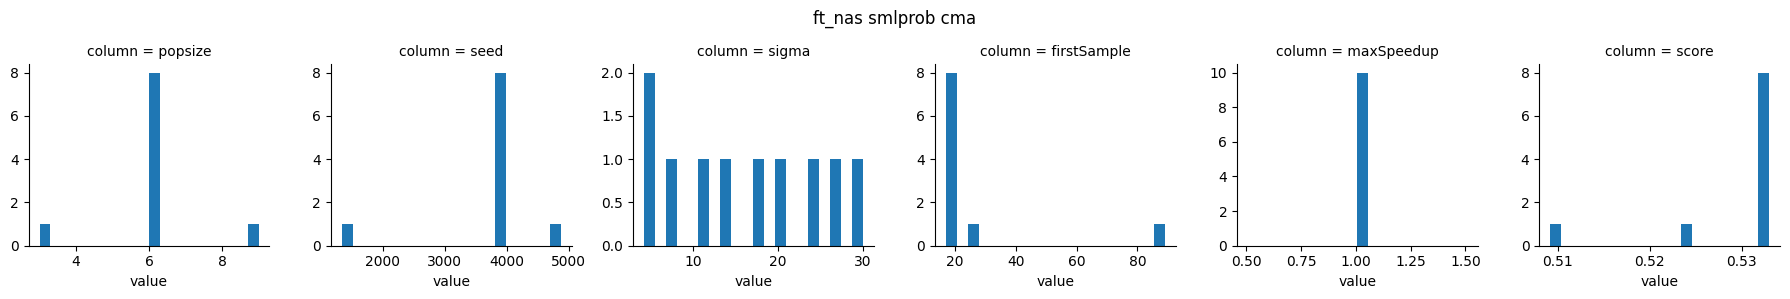

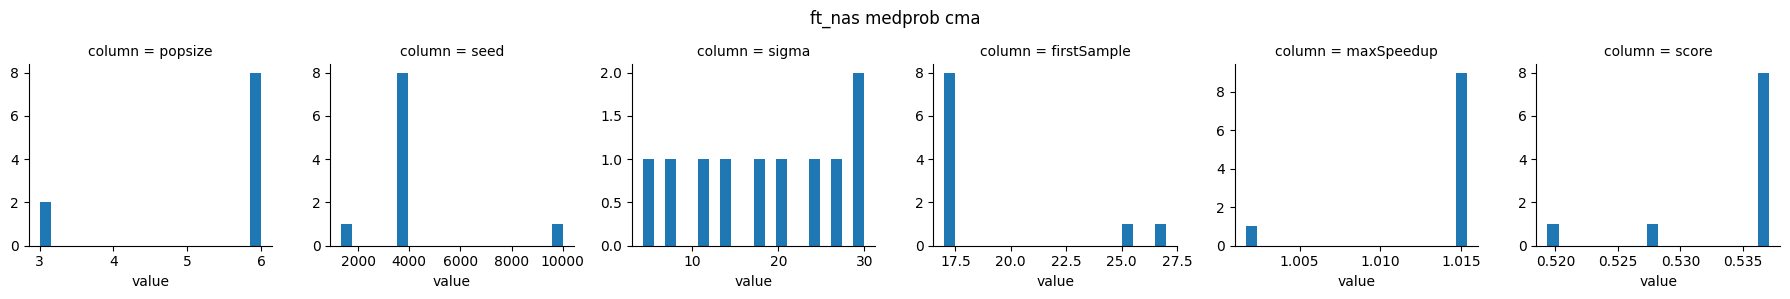

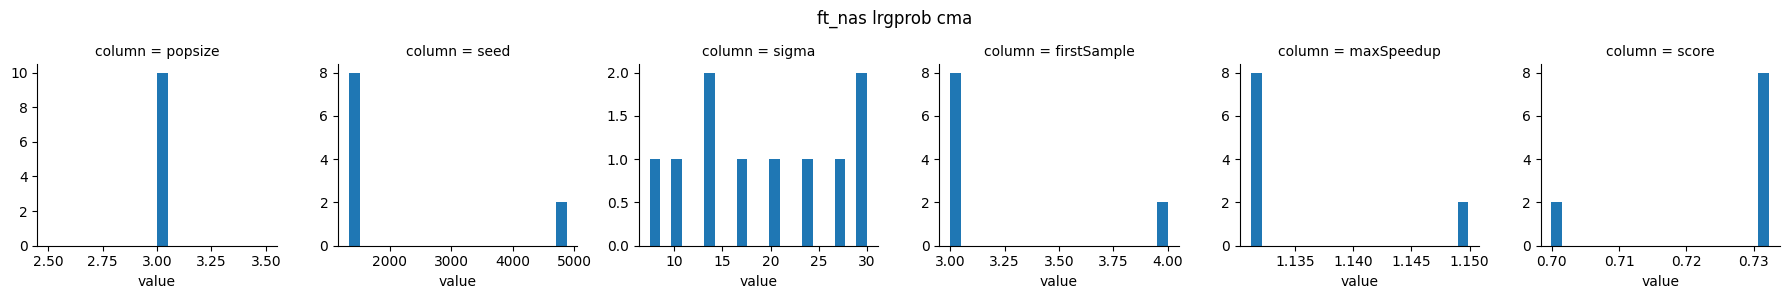

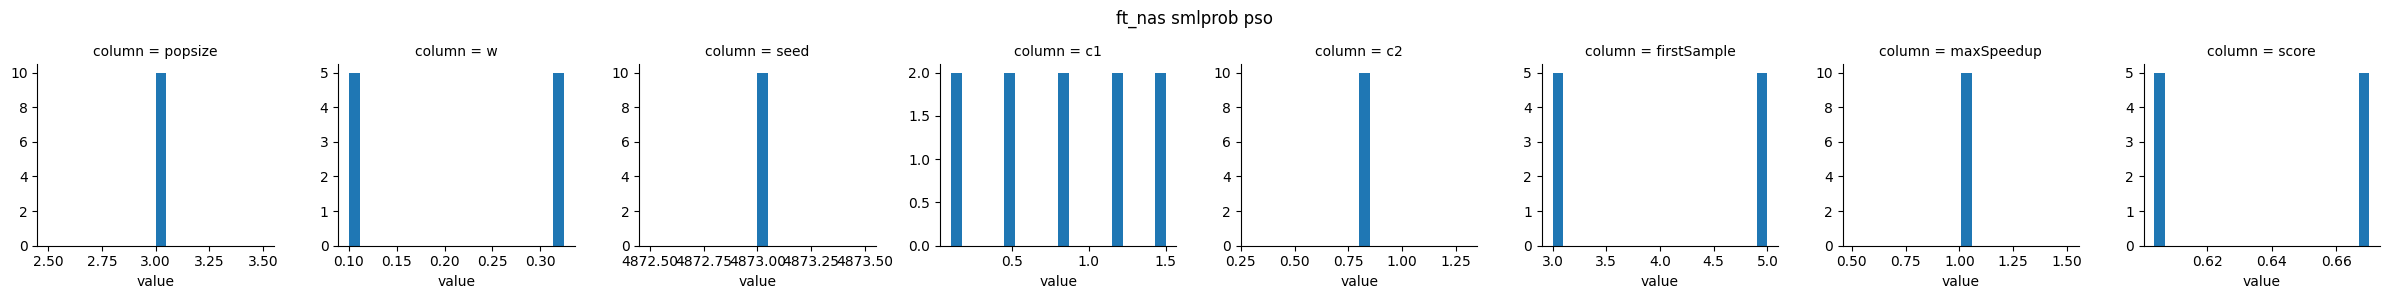

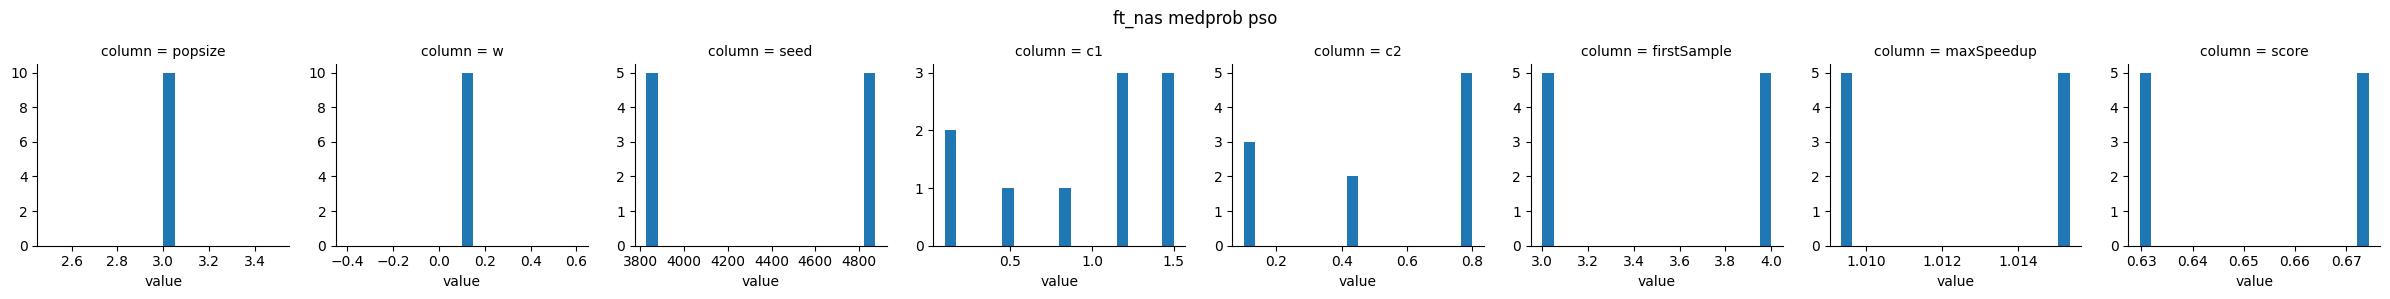

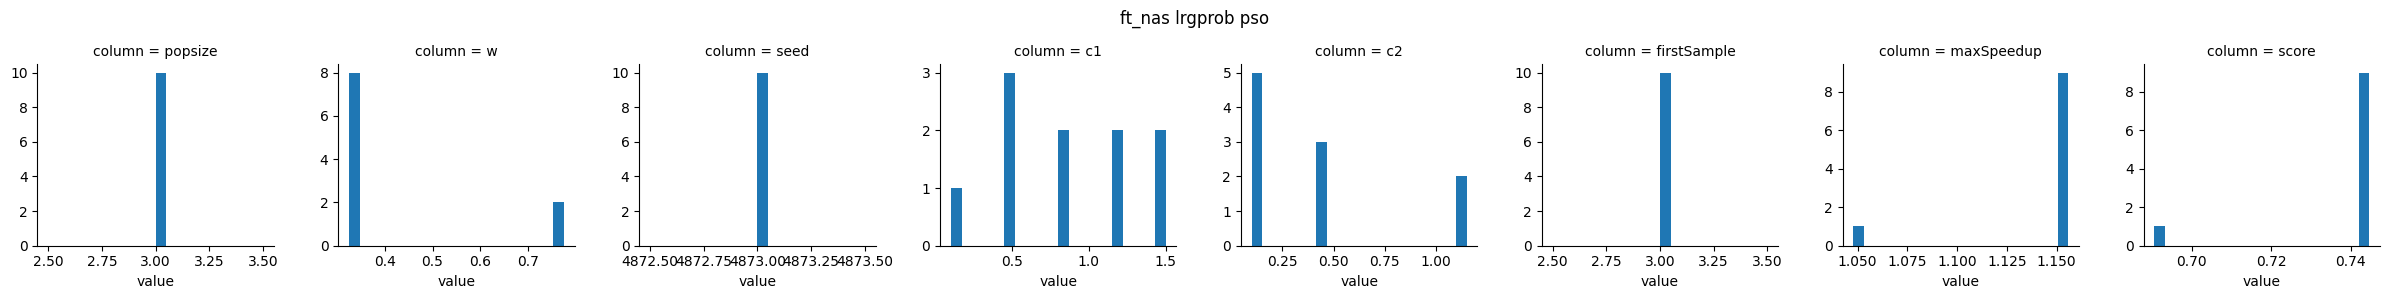

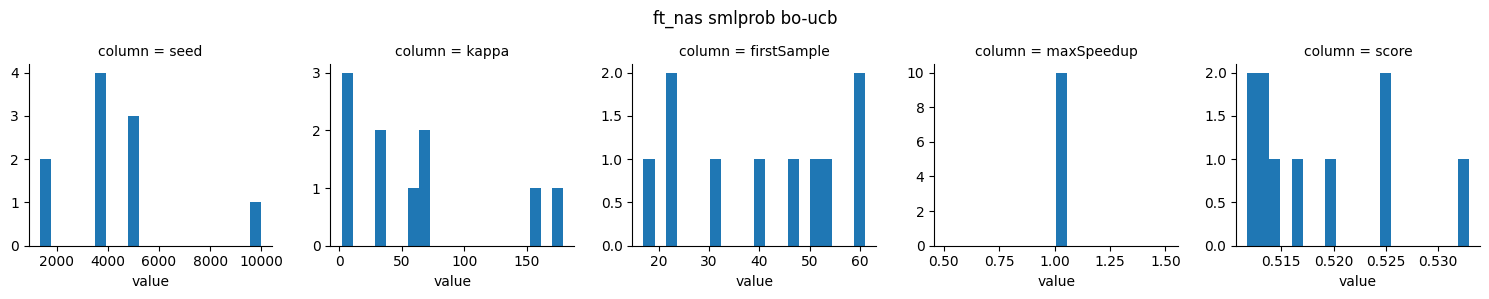

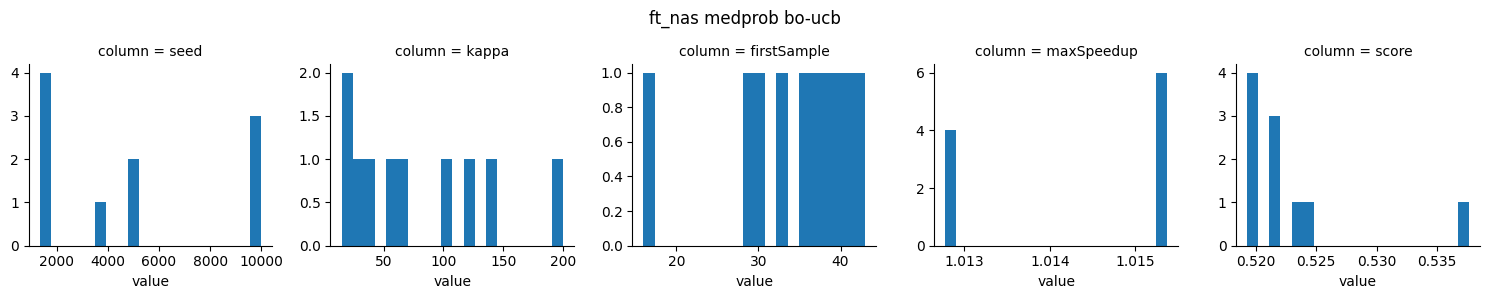

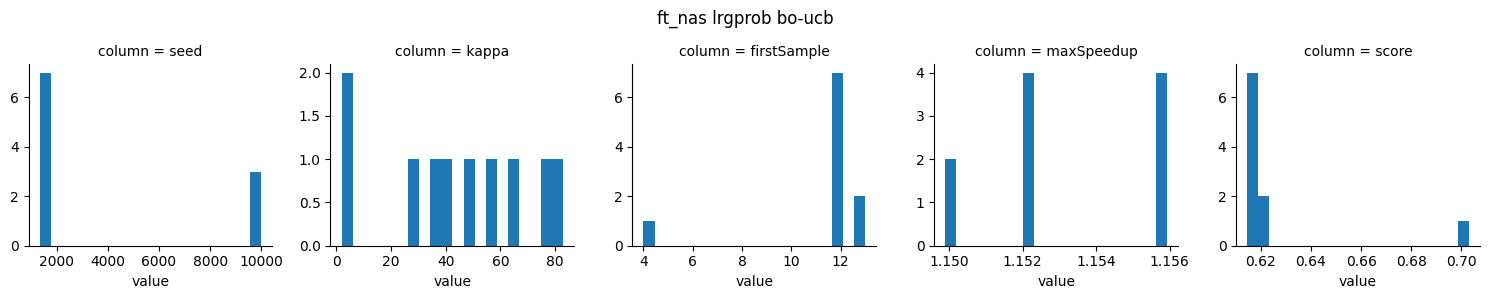

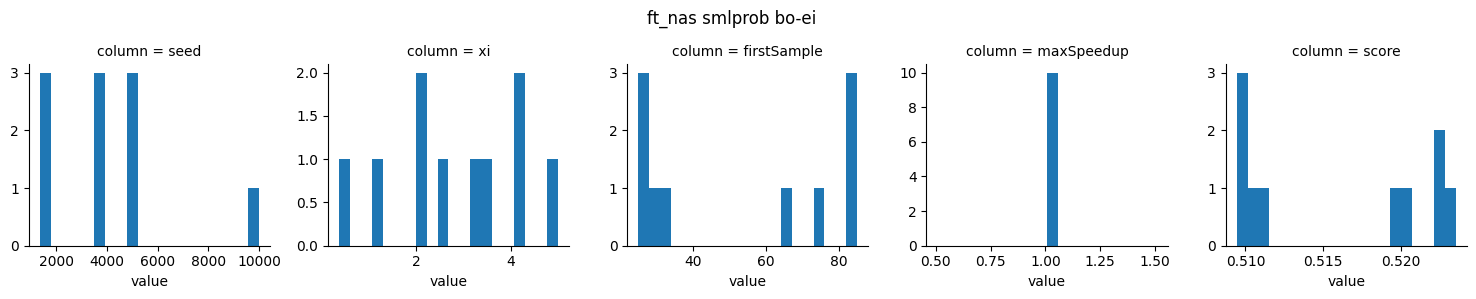

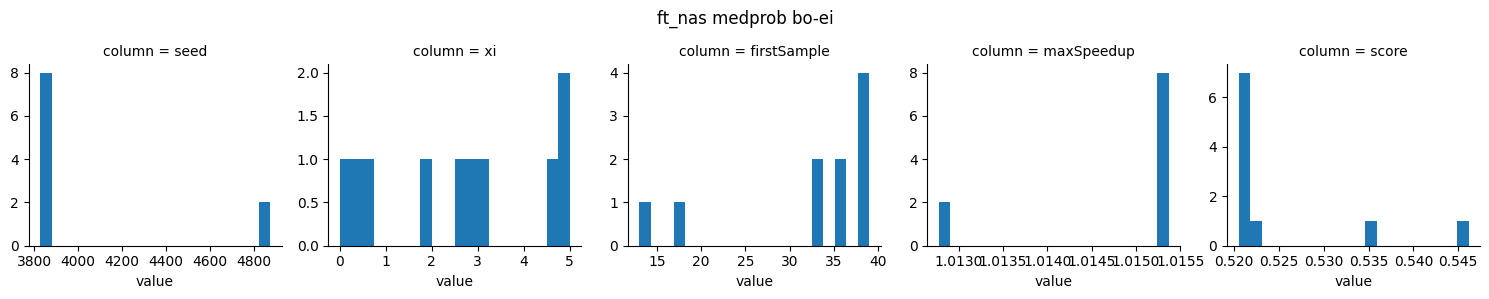

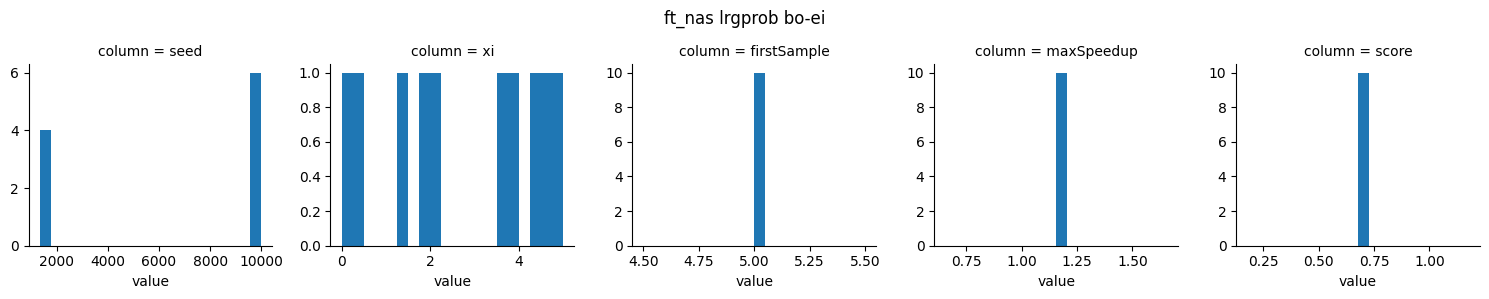

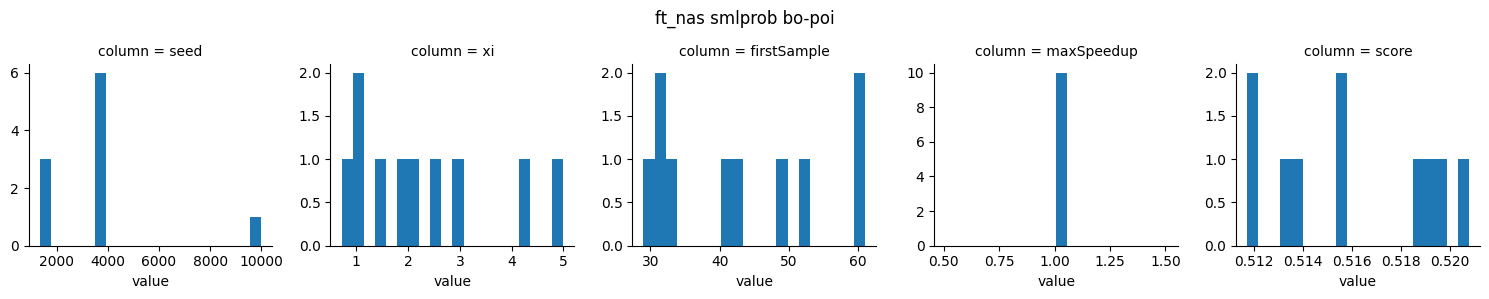

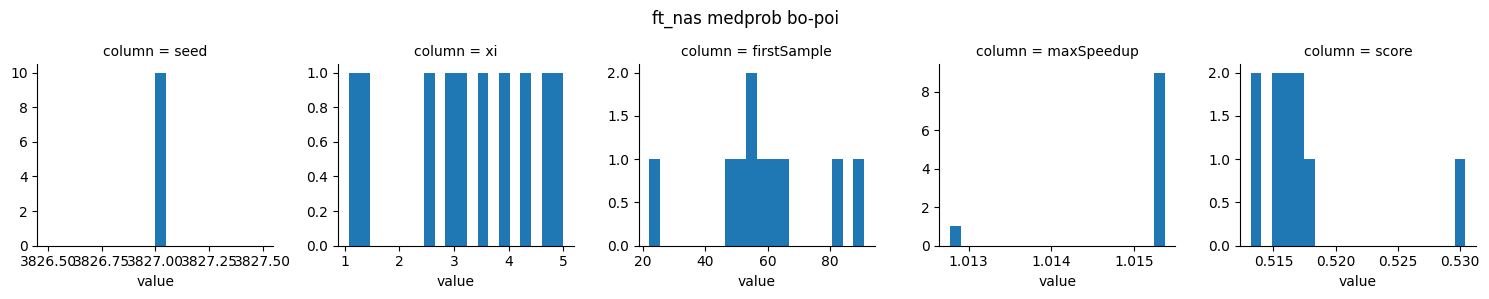

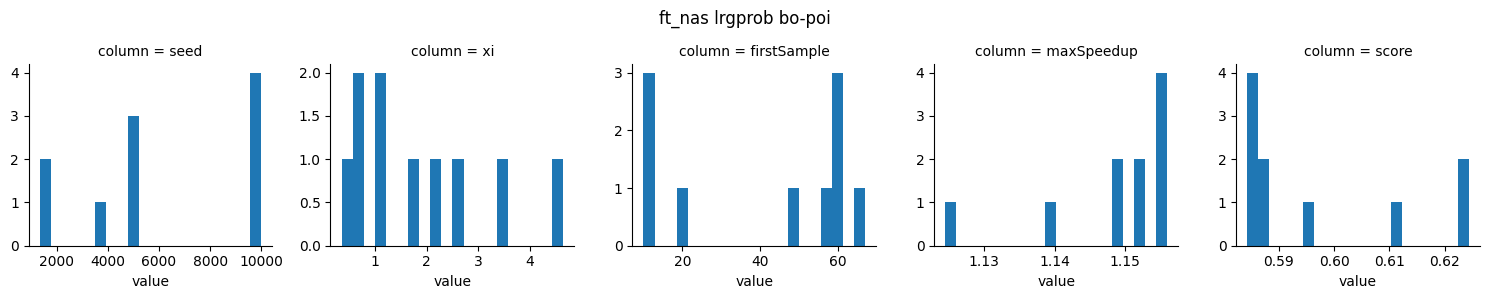

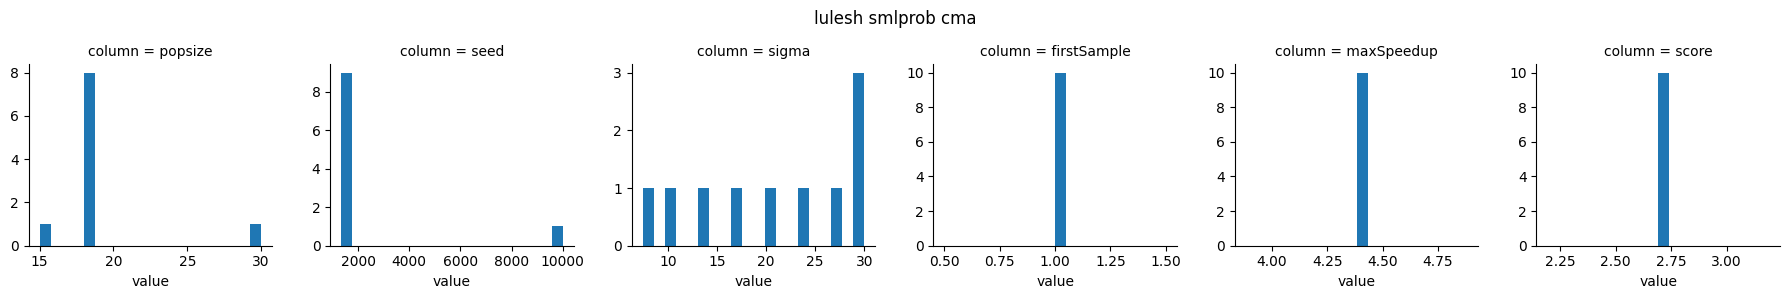

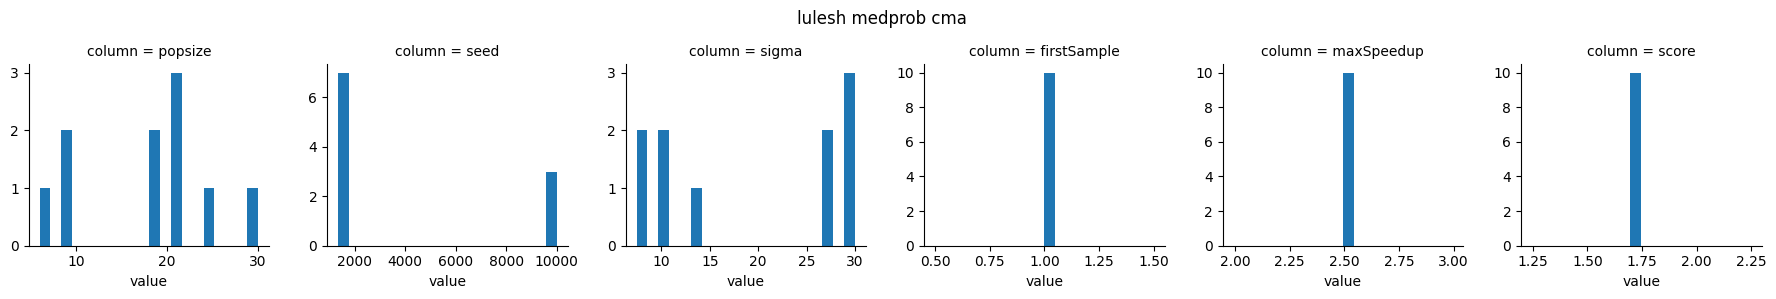

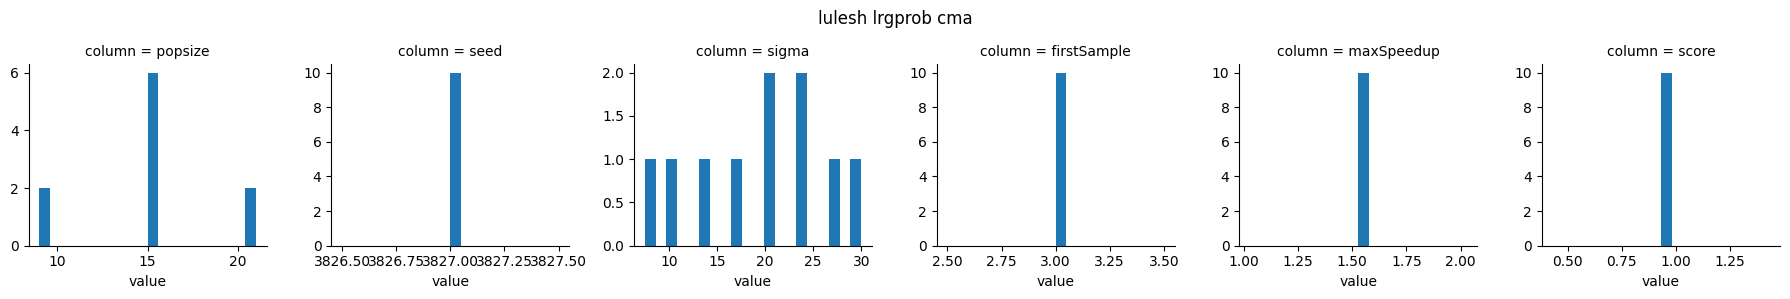

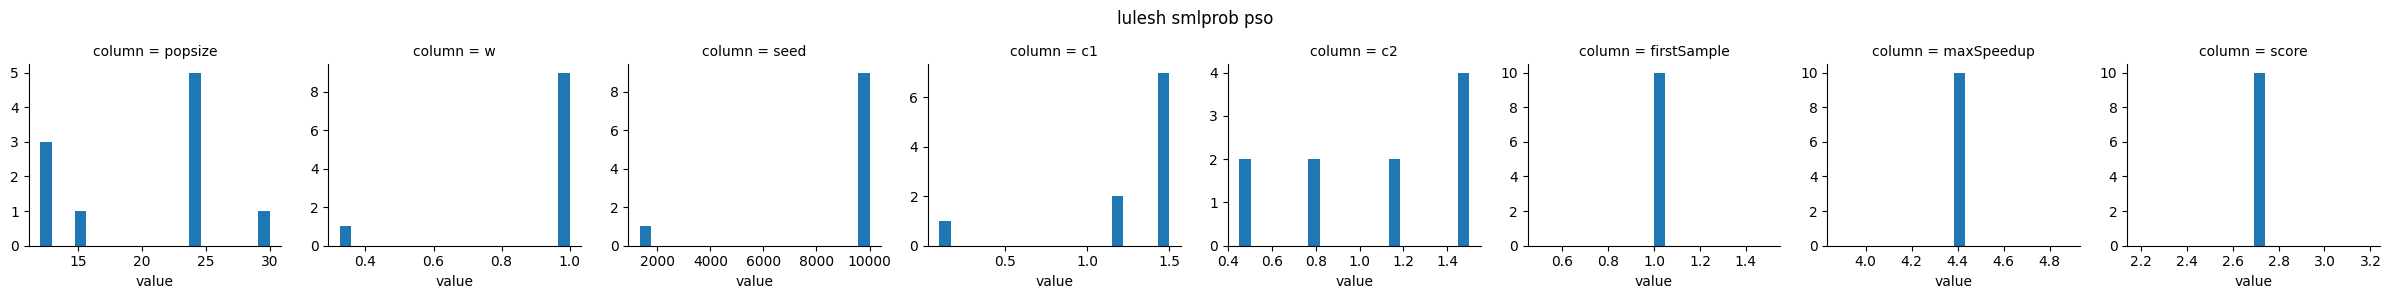

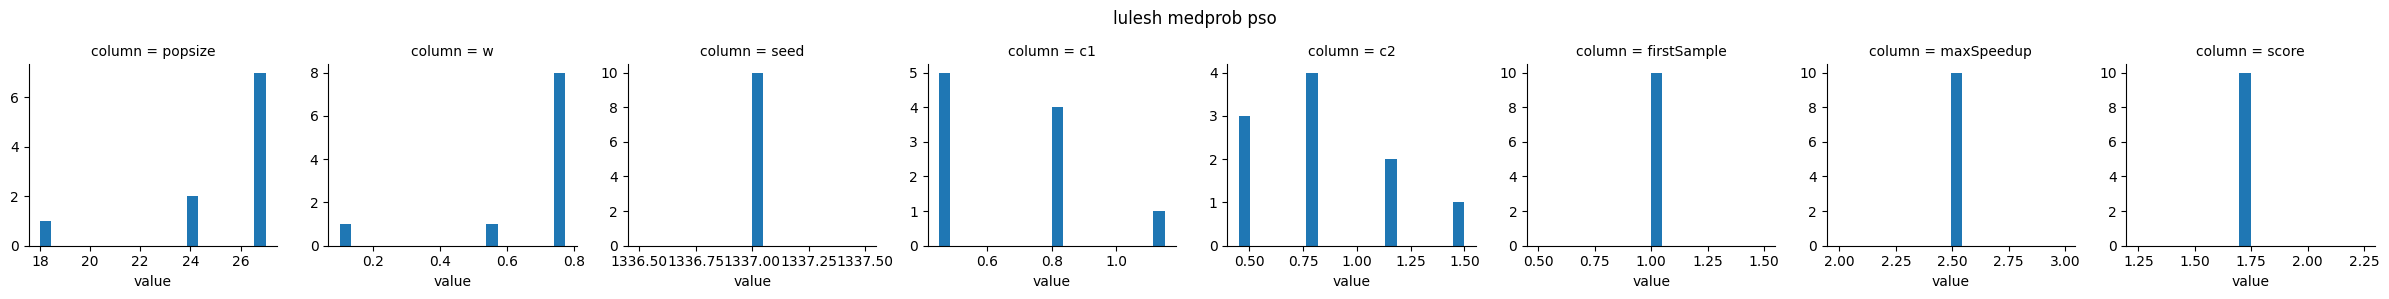

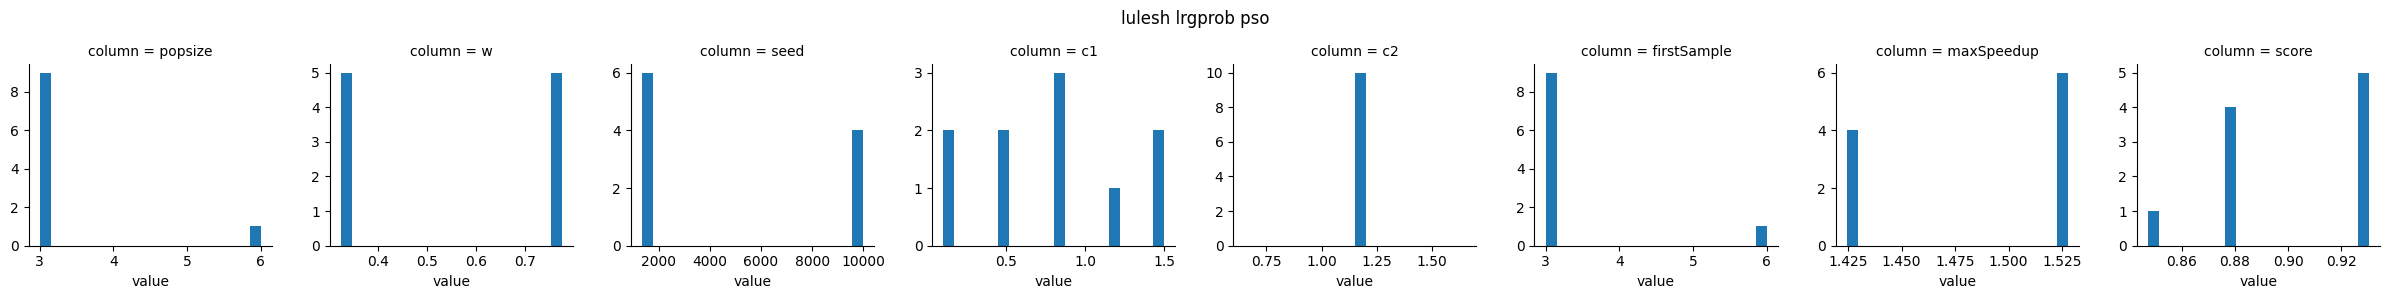

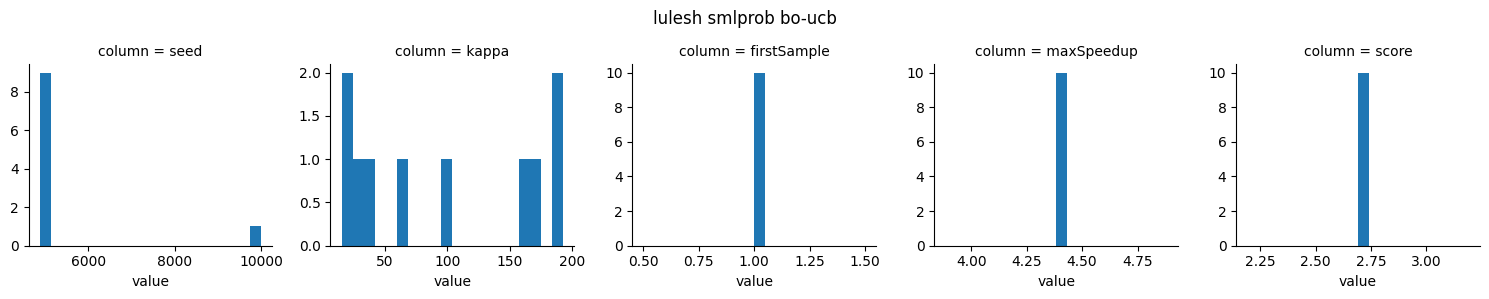

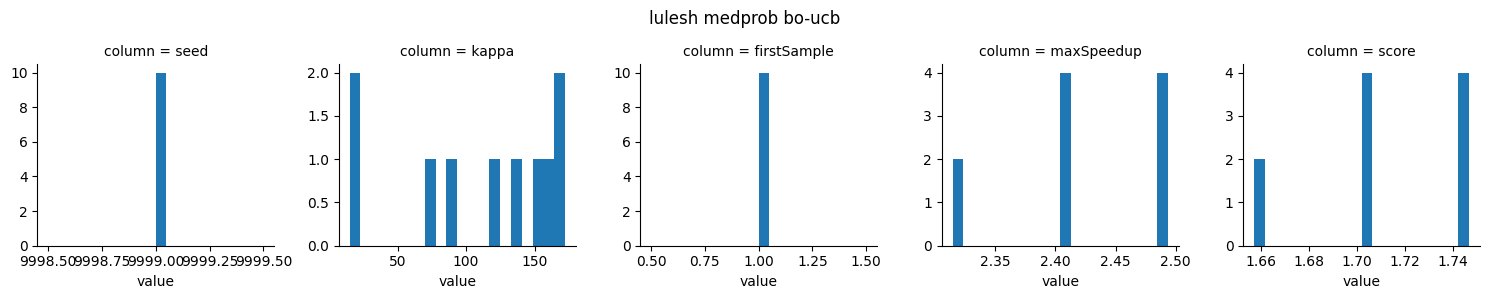

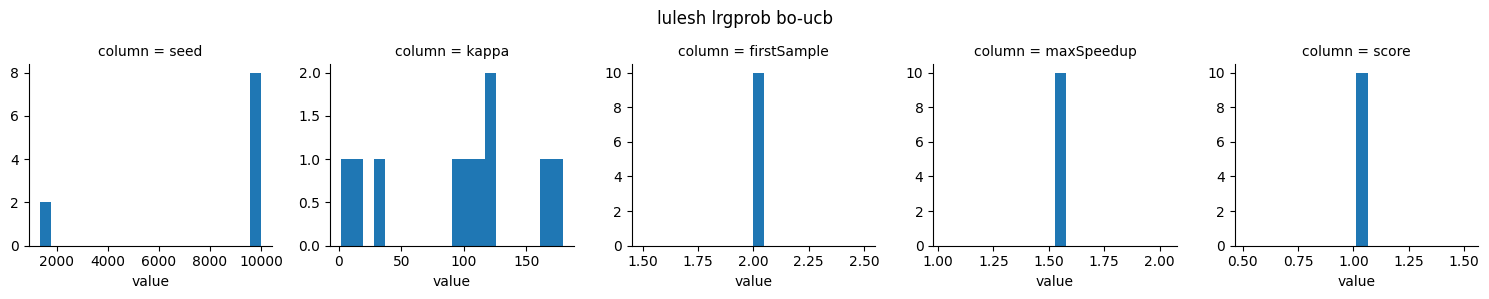

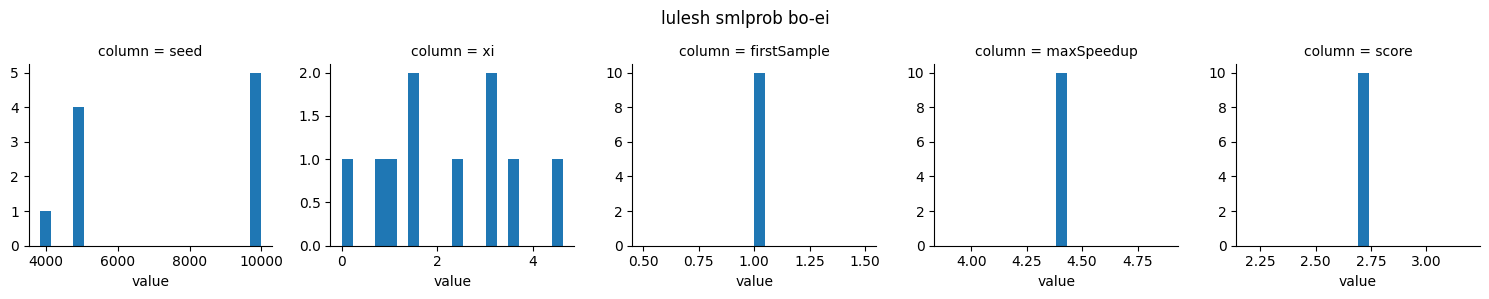

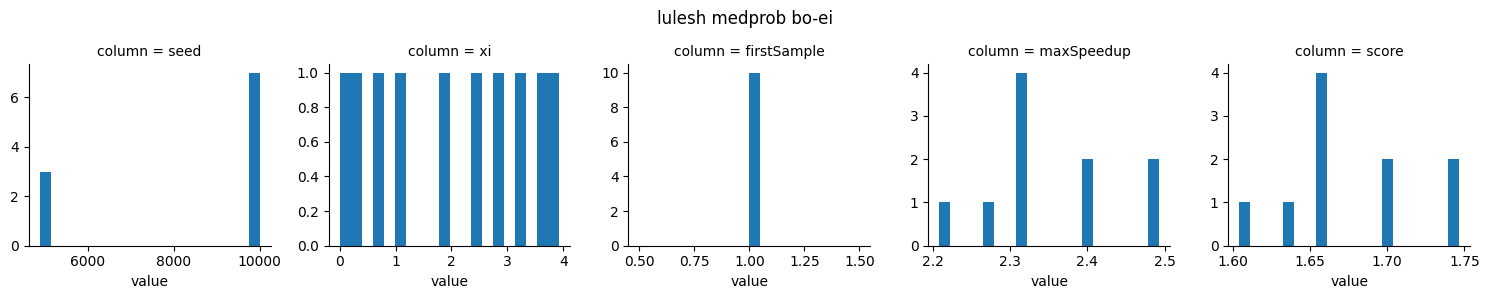

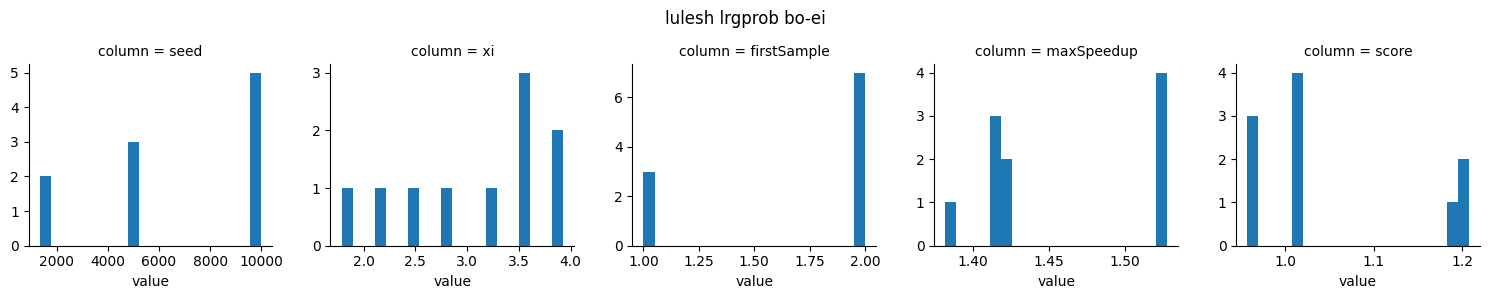

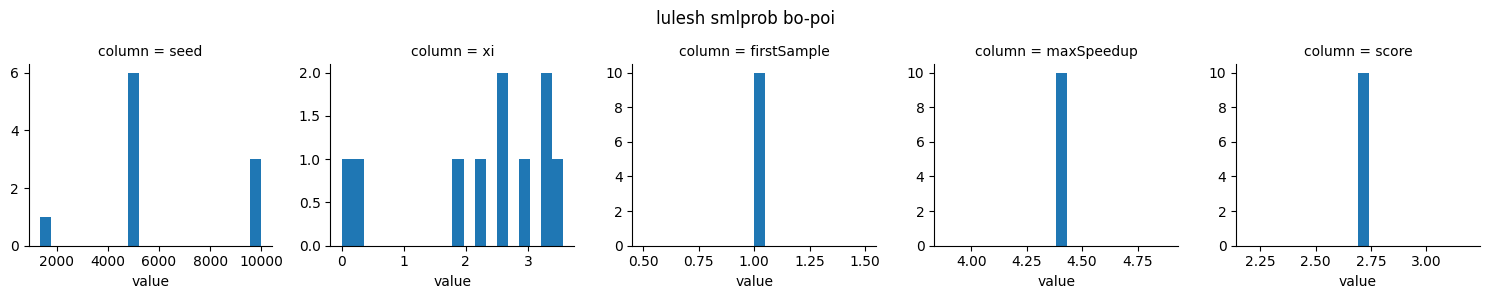

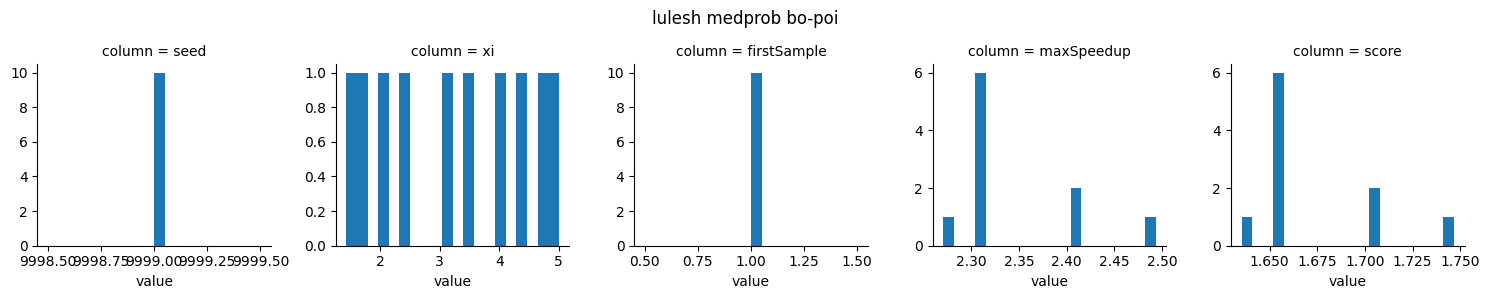

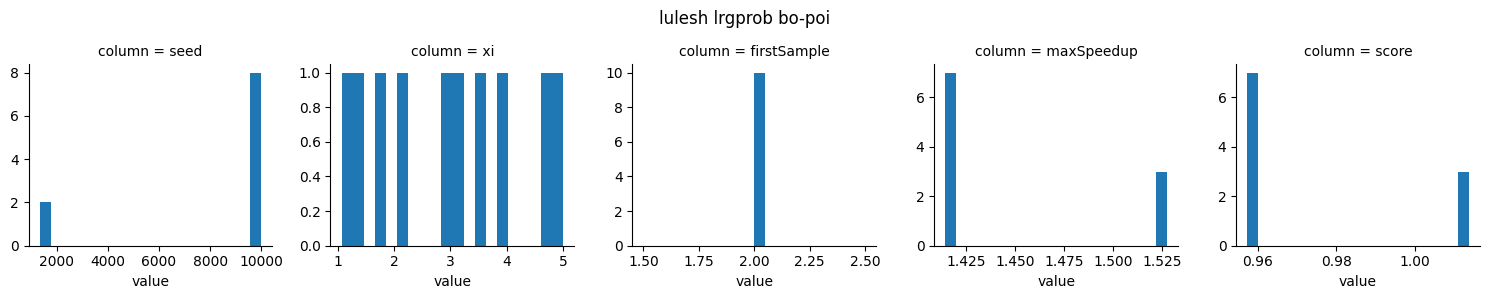

In [14]:
plotTopPoints(overallDF, 'bt_nas')
plotTopPoints(overallDF, 'hpcg')
plotTopPoints(overallDF, 'ft_nas')
plotTopPoints(overallDF, 'lulesh')

In [15]:
#fig = px.scatter(overallDF, x='globalSample', y='xtime', color='method', 
#					 facet_row='probsize', facet_col='progname')

#fig.show()